<a href="https://colab.research.google.com/github/MirtoSpatha/Energy-Time-Series-Forecasting/blob/main/Energy_Demand_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Total Energy Demand (Load) Forecasting in a National Level**

Author: Myrto Spatha

This project is conducted for my Internship and is part of my Undergraduate Thesis in Transformer Neural Network Architecture.

The goal is to perform a **single hour forecasting** task for the **electricity demand in Spain** based on the actual load for the previous 24 hours in a period of 4 years (2015-2018) (**Univariate Time Series Forecasting**).

The **data** were collected by the following Kaggle dataset (https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather)  which contains energy and weather data in an hourly frequency for the time period 2015-2018 (**time series data**) (details in the Data Exploration and Cleaning Section).

The **models** I implement are the following: Linear Regression, Simple Dense Neural Network, Support Vector Machines, Transformer Neural Network Architecture. I made this assumption as there is no Kaggle notebook that implements these techniques for this dataset (except for Linear Regression which is used as a baseline model).

All those methods are trained until 2018-08-07 and are tested until 2018-12-31.

The **experiments** where operated in a Google Colab environment to get access to a free GPU and be able to share my code with others easily.

The following notebook presents a methodology for a beginner data analyst/machine learning engineer who wants to operate/specialize in the Energy Sector or in Time Series Data Analysis.

The preprocessing, visualization and feature engineering where based on the following Kaggle notebook: https://www.kaggle.com/code/dimitriosroussis/electricity-price-forecasting-with-dnns-eda

The simplified version of Transformer Architecture was based on the following project: https://github.com/mounalab/Multivariate-time-series-forecasting-keras/blob/main/Transformer.py


##Drive Mount and Imports

Data is mounted to the drive to be able to use it by the path /content/drive/MyDrive/Thesis/Transformer_Thesis/data.

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Useful Library imports:

In [85]:
!pip install tensorflow_addons
!pip install xlwings

import pandas as pd
import numpy as np
from math import sqrt
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import xlwings as xw

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf

import tensorflow as tf
import tensorflow_addons as tfa
import keras

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Data Exploration and Cleaning

The used dataset contains time series data (year-month-day and hour in UTC timesystem) for the total electricity demand and generation in Spain stored in Mw. It also contains the price of electricity in dollars/Mwh as well as a prediction for the total load (demand), the price of electricity and the generation of electricity by wind and solar power.

### Data Load

Data is Loaded from Drive and gets stored into a DataFrame.

In [86]:
path = "/content/drive/MyDrive/Thesis/Transformer_Thesis/data/energy_dataset.csv"
df = pd.read_csv(path, parse_dates=['time'])

df

time  generation biomass  \
0      2015-01-01 00:00:00+01:00               447.0   
1      2015-01-01 01:00:00+01:00               449.0   
2      2015-01-01 02:00:00+01:00               448.0   
3      2015-01-01 03:00:00+01:00               438.0   
4      2015-01-01 04:00:00+01:00               428.0   
...                          ...                 ...   
35059  2018-12-31 19:00:00+01:00               297.0   
35060  2018-12-31 20:00:00+01:00               296.0   
35061  2018-12-31 21:00:00+01:00               292.0   
35062  2018-12-31 22:00:00+01:00               293.0   
35063  2018-12-31 23:00:00+01:00               290.0   

       generation fossil brown coal/lignite  \
0                                     329.0   
1                                     328.0   
2                                     323.0   
3                                     254.0   
4                                     187.0   
...                                     ...   
35059                                   0.0   
35060                                   0.0   
35061                                   0.0   
35062                                   0.0   
35063                                   0.0   

       generation fossil coal-derived gas  generation fossil gas  \
0                                     0.0                 4844.0   
1                                     0.0                 5196.0   
2                                     0.0                 4857.0   
3                                     0.0                 4314.0   
4                                     0.0                 4130.0   
...                                   ...                    ...   
35059                                 0.0                 7634.0   
35060                                 0.0                 7241.0   
35061                                 0.0                 7025.0   
35062                                 0.0                 6562.0   
35063                                 0.0                 6926.0   

       generation fossil hard coal  generation fossil oil  \
0                           4821.0                  162.0   
1                           4755.0                  158.0   
2                           4581.0                  157.0   
3                           4131.0                  160.0   
4                           3840.0                  156.0   
...                            ...                    ...   
35059                       2628.0                  178.0   
35060                       2566.0                  174.0   
35061                       2422.0                  168.0   
35062                       2293.0                  163.0   
35063                       2166.0                  163.0   

       generation fossil oil shale  generation fossil peat  \
0                              0.0                     0.0   
1                              0.0                     0.0   
2                              0.0                     0.0   
3                              0.0                     0.0   
4                              0.0                     0.0   
...                            ...                     ...   
35059                          0.0                     0.0   
35060                          0.0                     0.0   
35061                          0.0                     0.0   
35062                          0.0                     0.0   
35063                          0.0                     0.0   

       generation geothermal  ...  generation waste  generation wind offshore  \
0                        0.0  ...             196.0                       0.0   
1                        0.0  ...             195.0                       0.0   
2                        0.0  ...             196.0                       0.0   
3                        0.0  ...             191.0                       0.0   
4                        0.0  ...             189.0                       0.0   
...      

### Data Exploration

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [88]:
df.describe().transpose()

count          mean  \
generation biomass                           35045.0    383.513540   
generation fossil brown coal/lignite         35046.0    448.059208   
generation fossil coal-derived gas           35046.0      0.000000   
generation fossil gas                        35046.0   5622.737488   
generation fossil hard coal                  35046.0   4256.065742   
generation fossil oil                        35045.0    298.319789   
generation fossil oil shale                  35046.0      0.000000   
generation fossil peat                       35046.0      0.000000   
generation geothermal                        35046.0      0.000000   
generation hydro pumped storage aggregated       0.0           NaN   
generation hydro pumped storage consumption  35045.0    475.577343   
generation hydro run-of-river and poundage   35045.0    972.116108   
generation hydro water reservoir             35046.0   2605.114735   
generation marine                            35045.0      0.000000   
generation nuclear                           35047.0   6263.907039   
generation other                             35046.0     60.228585   
generation other renewable                   35046.0     85.639702   
generation solar                             35046.0   1432.665925   
generation waste                             35045.0    269.452133   
generation wind offshore                     35046.0      0.000000   
generation wind onshore                      35046.0   5464.479769   
forecast solar day ahead                     35064.0   1439.066735   
forecast wind offshore eday ahead                0.0           NaN   
forecast wind onshore day ahead              35064.0   5471.216689   
total load forecast                          35064.0  28712.129962   
total load actual                            35028.0  28696.939905   
price day ahead                              35064.0     49.874341   
price actual                                 35064.0     57.884023   

                                                     std       min  \
generation biomass                             85.353943      0.00   
generation fossil brown coal/lignite          354.568590      0.00   
generation fossil coal-derived gas              0.000000      0.00   
generation fossil gas                        2201.830478      0.00   
generation fossil hard coal                  1961.601013      0.00   
generation fossil oil                          52.520673      0.00   
generation fossil oil shale                     0.000000      0.00   
generation fossil peat                          0.000000      0.00   
generation geothermal                           0.000000      0.00   
generation hydro pumped storage aggregated           NaN       NaN   
generation hydro pumped storage consumption   792.406614      0.00   
generation hydro run-of-river and poundage    400.777536      0.00   
generation hydro water reservoir             1835.199745      0.00   
generation marine                               0.000000      0.00   
generation nuclear                            839.667958      0.00   
generation other                               20.238381      0.00   
generation other renewable                     14.077554      0.00   
generation solar                             1680.119887      0.00   
generation waste                               50.195536      0.00   
generation wind offshore                        0.000000      0.00   
generation wind onshore                      3213.691587      0.00   
forecast solar day ahead                     1677.703355      0.00   
forecast wind offshore eday ahead                    NaN       NaN   
forecast wind onshore day ahead              3176.312853    237.00   
total load forecast                          4594.100854  18105.00   
total load actual                            4574.987950  18041.00   
price day ahead                                14.618900      2.06   
price actual                                   14.204083

The 'time' column, which we also want to function as the index of the observations in a time-series, has not been parsed correctly and is recognized as an object.

In [89]:
df['time'] = pd.to_datetime(df['time'], utc=True, infer_datetime_format=True)
df = df.set_index('time')

Test if total generation amount is the same as total load.

For an energy system to be feasible, we need the total generation to be greater or equal to the total load.

In [90]:
df['generation all'] = df['generation biomass'] + df['generation fossil brown coal/lignite'] + df["generation fossil hard coal"] + df["generation nuclear"] + df["generation solar"] + df["generation hydro pumped storage consumption"] + df["generation fossil gas"] + df["generation fossil oil"] + df["generation hydro run-of-river and poundage"] + df["generation hydro water reservoir"] + df["generation other"] + df["generation other renewable"] + df["generation waste"] + df["generation wind onshore"]

In [91]:
print(df["generation all"] - df["total load actual"])

print(df["generation all"].sum())
print(df["total load actual"].sum())

time
2014-12-31 23:00:00+00:00    2866.0
2015-01-01 00:00:00+00:00    3436.0
2015-01-01 01:00:00+00:00    4062.0
2015-01-01 02:00:00+00:00    3937.0
2015-01-01 03:00:00+00:00    4356.0
                              ...  
2018-12-31 18:00:00+00:00   -4238.0
2018-12-31 19:00:00+00:00   -4522.0
2018-12-31 20:00:00+00:00   -4084.0
2018-12-31 21:00:00+00:00   -3053.0
2018-12-31 22:00:00+00:00   -1850.0
Length: 35064, dtype: float64
1003515456.0
1005196411.0


### Drop Unusable Columns

Inside the dataset there are columns that have no values, or columns that have very little values with no significance. Those columns are irrelevant to the dataset and thus need to be dropped.

In [92]:
# drop nan columns

df.replace("", np.nan, inplace=True)

df.dropna(how='all', axis=1, inplace=True)

In [93]:
# drop mostly zero columns
nullcol = []
for item in df.columns:
  if(item == 'time'):
    continue
  if (len(df[df[item] != 0]) < 20):
    nullcol.append(item)
    for i in range(len(df[item])):
      if (df[item][i] !=0):
        value = df[item][i]

In [94]:
col = [item for item in nullcol]
df = df.drop(columns = col)

df.head()

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   

                           generation hydro run-of-river and poundage  \
time                                                                    
2014-12-31 23:00:00+00:00                                      1051.0   
2015-01-01 00:00:00+00:00                                      1009.0   
2015-01-01 01:00:00+00:00                                       973.0   
2015-01-01 02:00:00+00:00                                       949.0   
2015-01-01 03:00:00+00:00                                       953.0   

                           generation hydro water reservoir  \
time                                                          
2014-12-31 23:00:00+00:00                            1899.0   
2015-01-01 00:00:00+00:00                            1658.0   
2015-01-01 01:00:00+00:00                            1371.0   
2015-01-01 02:00:00+00:00                             779.0   
2015-01-01 03:00:00+00:00                             720.0   

                           generation nuclear  generation other  ...  \
time                                                             ...   
2014-12-31 23:00:00+00:00              7096.0              43.0  ...   
2015-01-01 00:00:00+00:00              7096.0              43.0  ...   
2015-01-01 01:00:00+00:00              7099.0              43.0  ...   
2015-01-01 02:00:00+00:00              7098.0              43.0  ...   
2015-01-01 03:00:00+00:00              7097.0              43.0  ...   

                           generation solar  generation waste  \
time                                                            
2014-12-31 23:00:00+00:00              49.0             196.0   
2015-01-01 00:00:00+00:00              50.0             195.0   
2015-01-01 01:00:00+00:00              50.

### Fill Missing Values

The method we use to fill missing values is linear interpolation (the missing value is replaced by the mean of the previous and next value).

In [95]:
dfn = df.loc[:,df.columns!='time']
df_filled = dfn.interpolate("linear")

In [96]:
df_filled

generation biomass  \
time                                            
2014-12-31 23:00:00+00:00               447.0   
2015-01-01 00:00:00+00:00               449.0   
2015-01-01 01:00:00+00:00               448.0   
2015-01-01 02:00:00+00:00               438.0   
2015-01-01 03:00:00+00:00               428.0   
...                                       ...   
2018-12-31 18:00:00+00:00               297.0   
2018-12-31 19:00:00+00:00               296.0   
2018-12-31 20:00:00+00:00               292.0   
2018-12-31 21:00:00+00:00               293.0   
2018-12-31 22:00:00+00:00               290.0   

                           generation fossil brown coal/lignite  \
time                                                              
2014-12-31 23:00:00+00:00                                 329.0   
2015-01-01 00:00:00+00:00                                 328.0   
2015-01-01 01:00:00+00:00                                 323.0   
2015-01-01 02:00:00+00:00                                 254.0   
2015-01-01 03:00:00+00:00                                 187.0   
...                                                         ...   
2018-12-31 18:00:00+00:00                                   0.0   
2018-12-31 19:00:00+00:00                                   0.0   
2018-12-31 20:00:00+00:00                                   0.0   
2018-12-31 21:00:00+00:00                                   0.0   
2018-12-31 22:00:00+00:00                                   0.0   

                           generation fossil gas  generation fossil hard coal  \
time                                                                            
2014-12-31 23:00:00+00:00                 4844.0                       4821.0   
2015-01-01 00:00:00+00:00                 5196.0                       4755.0   
2015-01-01 01:00:00+00:00                 4857.0                       4581.0   
2015-01-01 02:00:00+00:00                 4314.0                       4131.0   
2015-01-01 03:00:00+00:00                 4130.0                       3840.0   
...                                          ...                          ...   
2018-12-31 18:00:00+00:00                 7634.0                       2628.0   
2018-12-31 19:00:00+00:00                 7241.0                       2566.0   
2018-12-31 20:00:00+00:00                 7025.0                       2422.0   
2018-12-31 21:00:00+00:00                 6562.0                       2293.0   
2018-12-31 22:00:00+00:00                 6926.0                       2166.0   

                           generation fossil oil  \
time                                               
2014-12-31 23:00:00+00:00                  162.0   
2015-01-01 00:00:00+00:00                  158.0   
2015-01-01 01:00:00+00:00                  157.0   
2015-01-01 02:00:00+00:00                  160.0   
2015-01-01 03:00:00+00:00                  156.0   
...                                          ...   
2018-12-31 18:00:00+00:00                  178.0   
2018-12-31 19:00:00+00:00                  174.0   
2018-12-31 20:00:00+00:00                  168.0   
2018-12-31 21:00:00+00:00                  163.0   
2018-12-31 22:00:00+00:00                  163.0   

                           generation hydro pumped storage consumption  \
time                                                                     
2014-12-31 23:00:00+00:00                                        863.0   
2015-01-01 00:00:00+00:00                                        920.0   
2015-01-01 01:00:00+00:00                                       1164.0   
2015-01-01 02:00:00+00:00                                       1503.0   
2015-01-01 03:00:00+00:00                                       1826.0   
...                                                                ...   
2018-12-31 18:00:00+00:00                                          1.0   
2018-12-31 19:00:00+00:00                                          1.0   
2018-12-31 20:00:00+00:00                     

## Visualization

### Useful visualizations and insights

In [97]:
# Define a function to plot different types of time-series

def plot_series(df=None, column=None, series=pd.Series([]),
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series
    created by the user. The user can define either the 'df' and the 'column'
    or the 'series' and additionally, can also define the 'label', the
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-97-12e47236ed59>:3: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



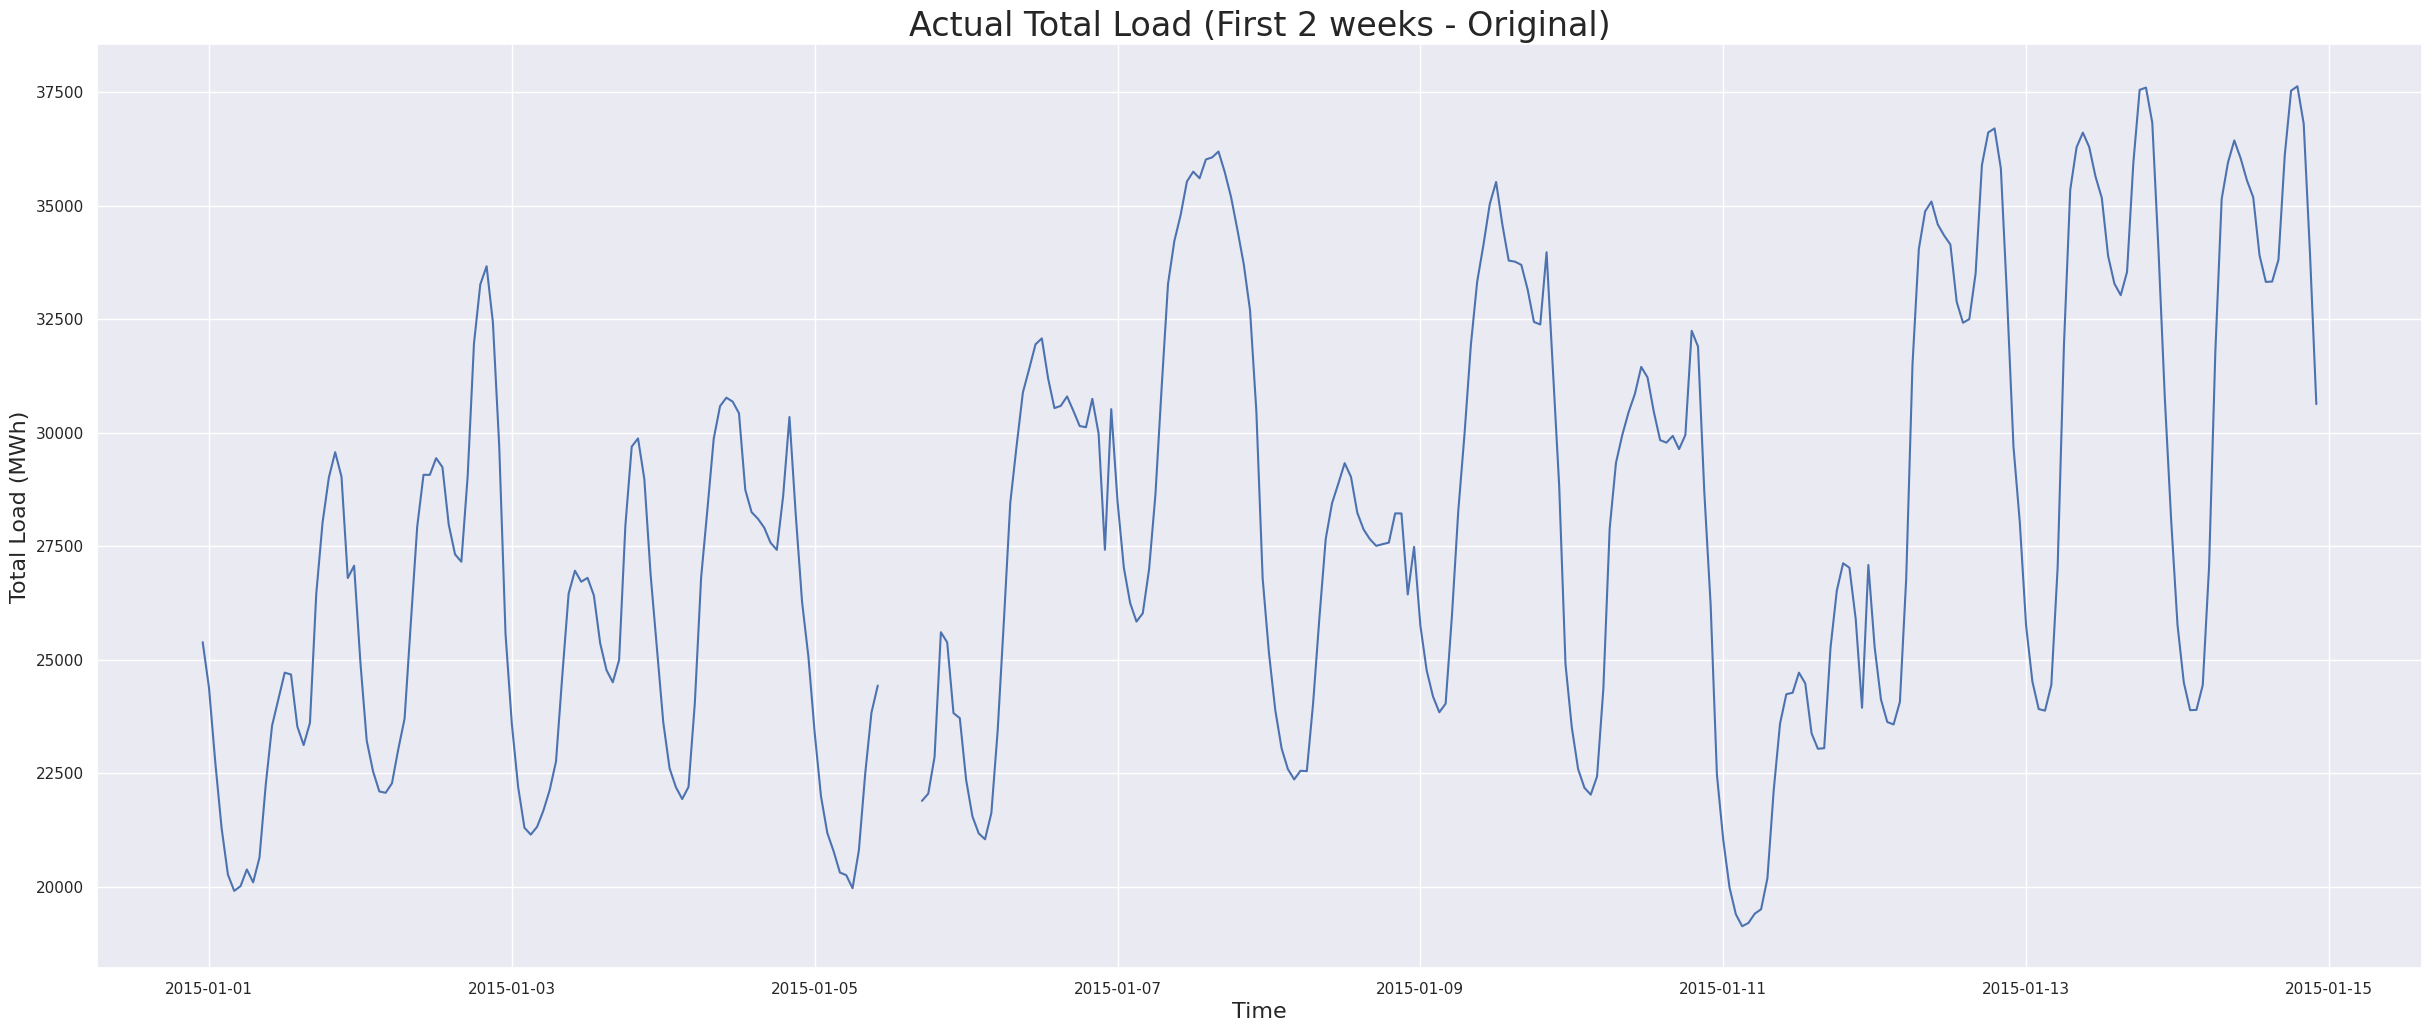

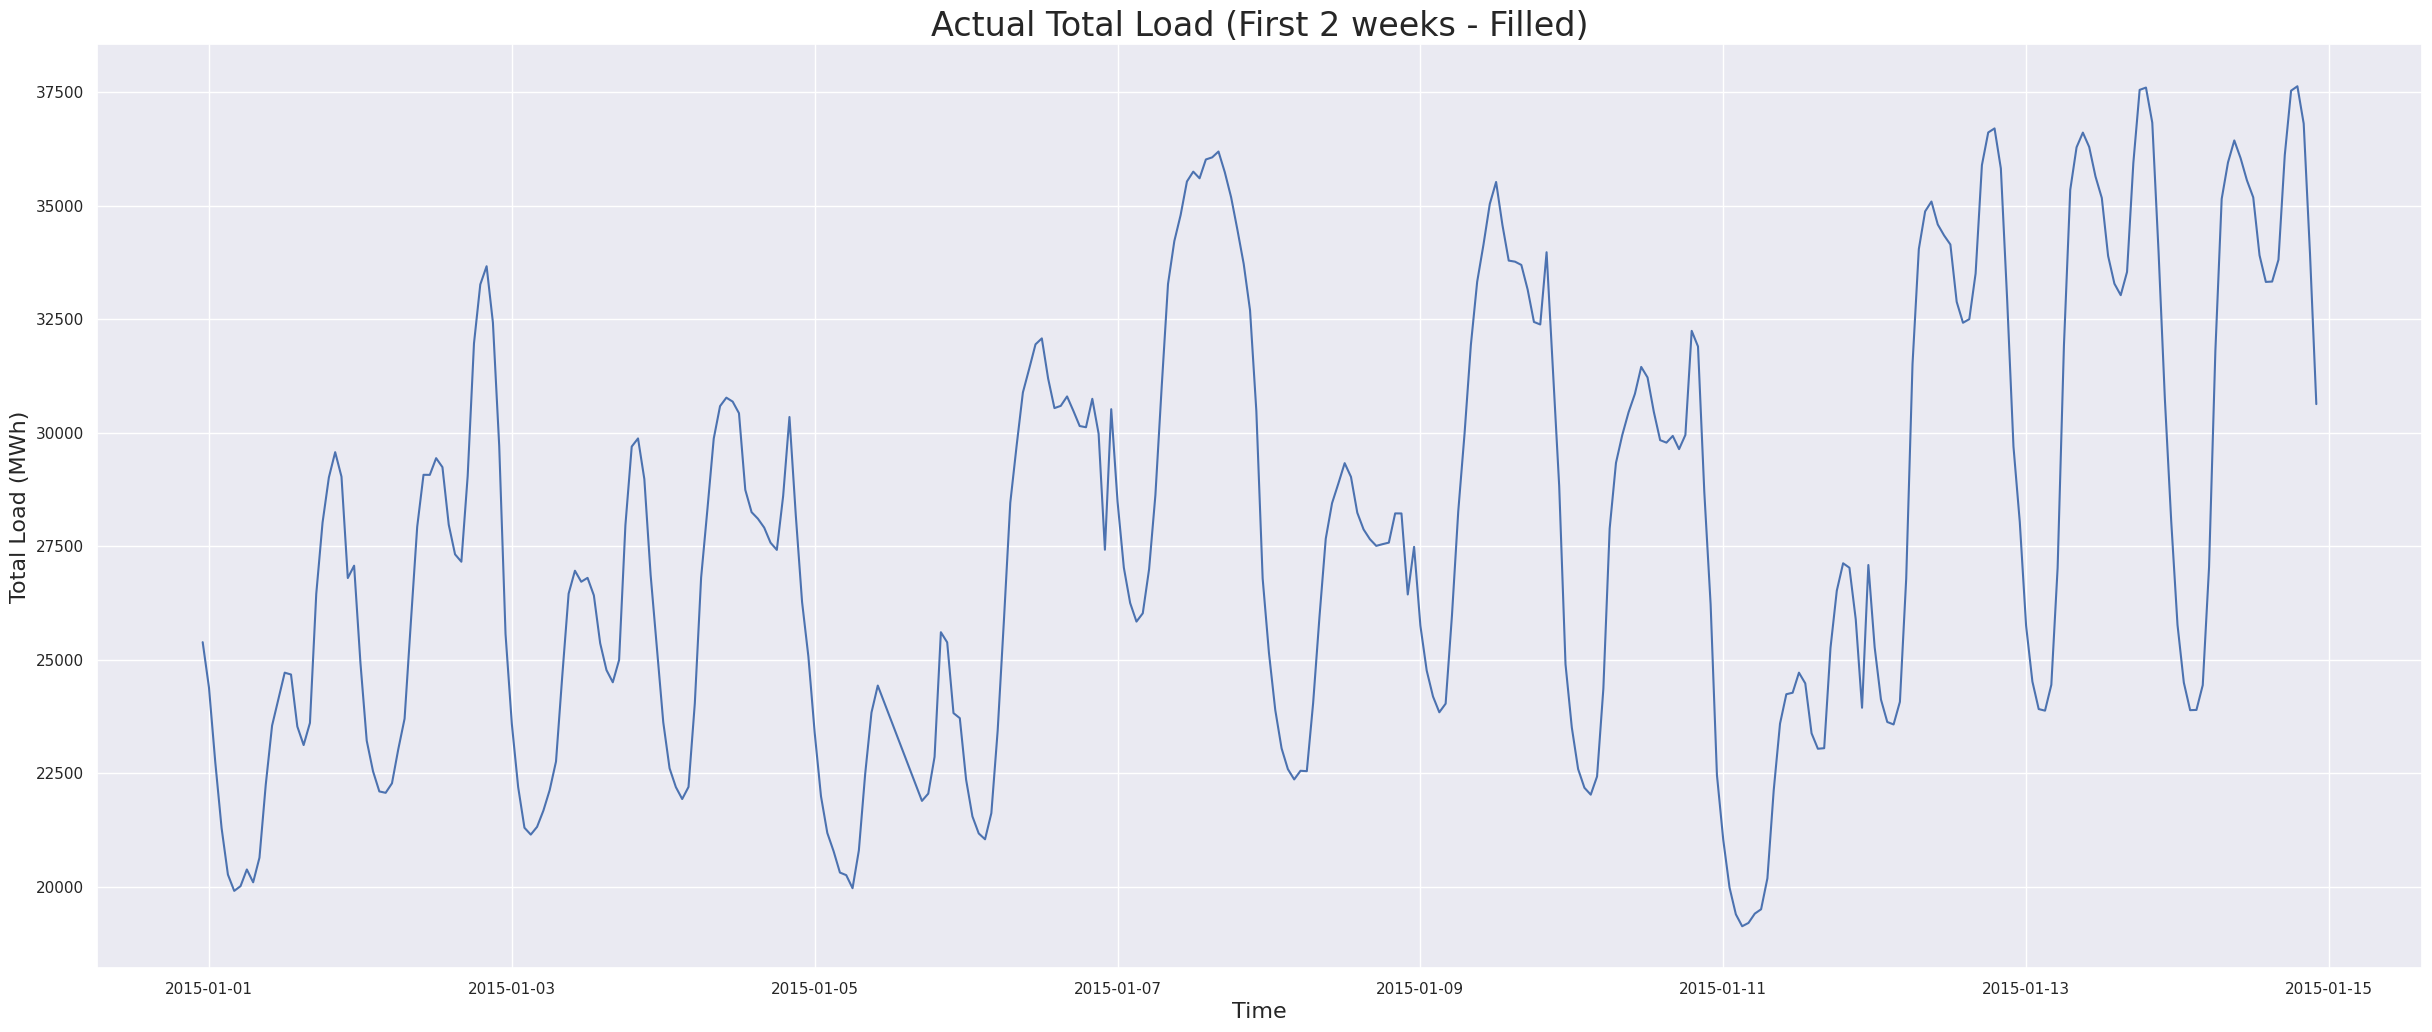

In [98]:
# Zoom into the plot of the hourly (actual) total load before filling missing values
ax = plot_series(df=df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

# Zoom into the plot of the hourly (actual) total load after filling missing values
ax = plot_series(df=df_filled, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Filled)', end=24*7*2)
plt.show()

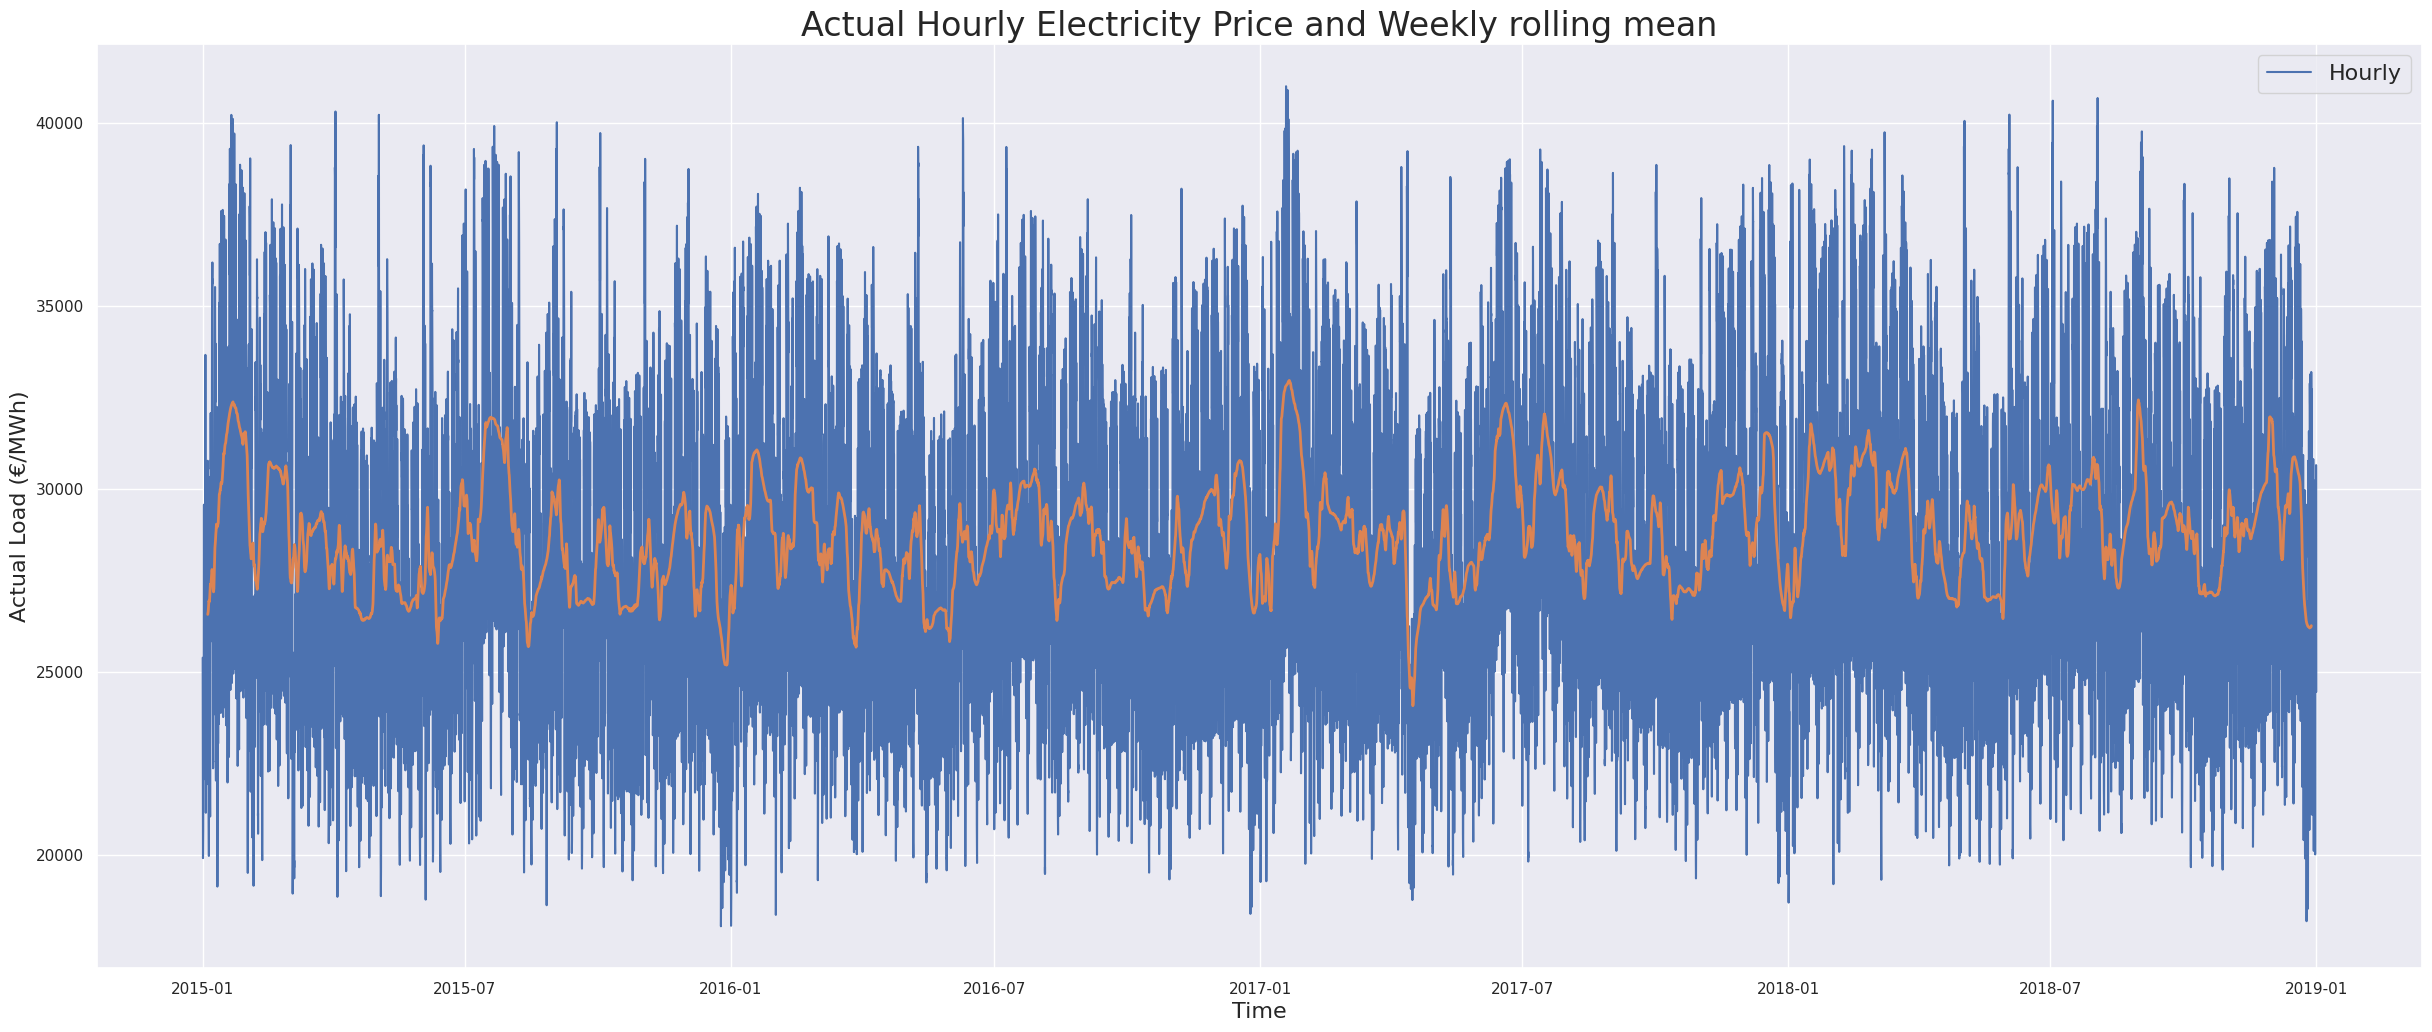

In [99]:
# Plot the hourly actual electricity load, along with the weekly rolling mean
rolling = df_filled['total load actual'].rolling(24*7, center=True).mean()
ax = plot_series(df_filled, 'total load actual', label='Hourly', ylabel='Actual Load (€/MWh)',
                 title='Actual Hourly Electricity Price and Weekly rolling mean')
ax.plot(rolling, linestyle='-', linewidth=2, label='Weekly rolling mean')
plt.show()

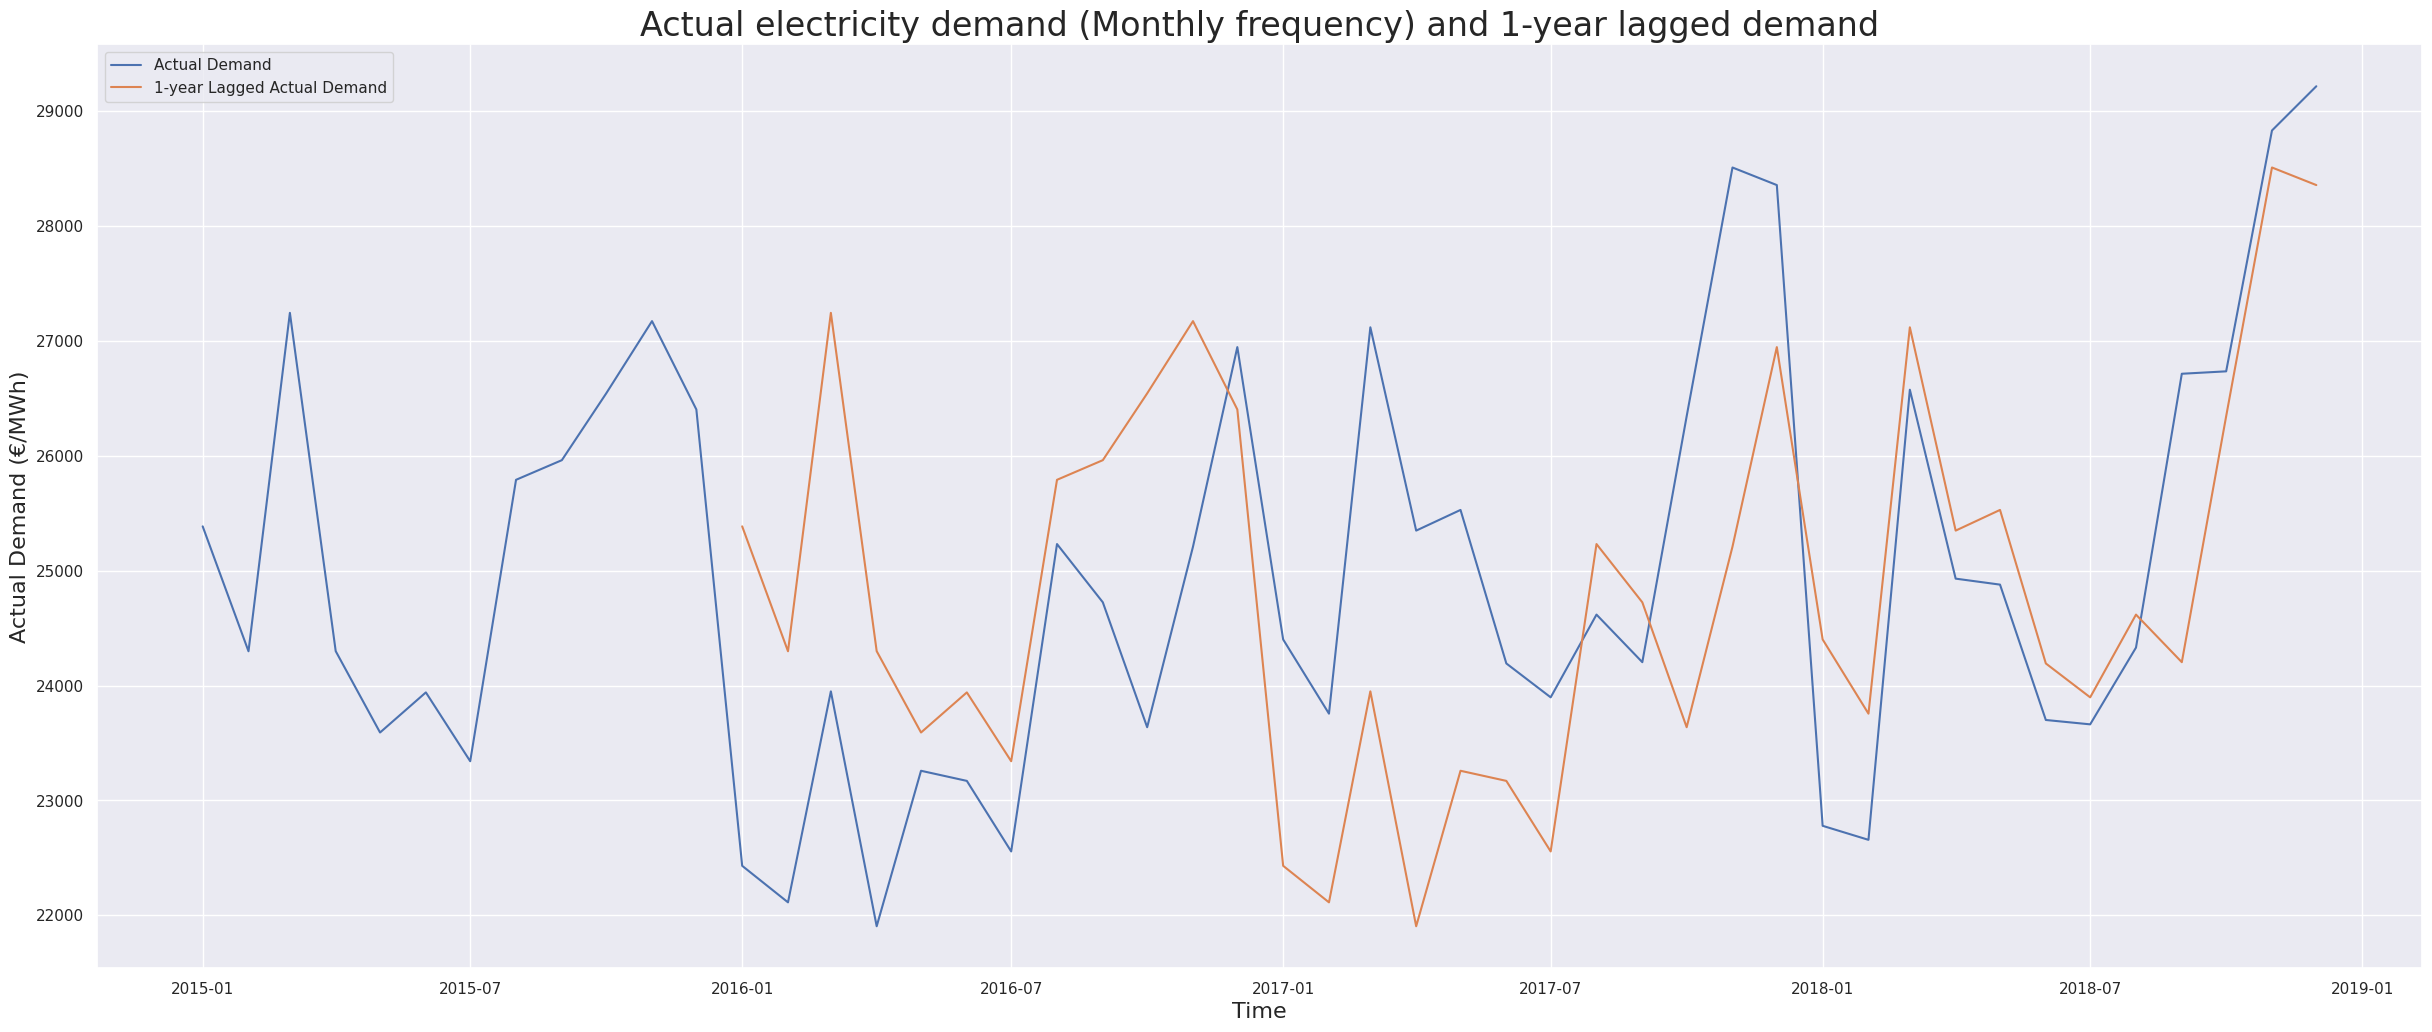

In [100]:
# Plot the electricity demand (monthly frequence) along with its 1-year lagged series

monthly = df_filled['total load actual'].asfreq('M')
ax = plot_series(series=monthly, ylabel='Actual Demand (€/MWh)',
                 title='Actual electricity demand (Monthly frequency) and 1-year lagged demand')
shifted = df_filled['total load actual'].asfreq('M').shift(12)
ax.plot(shifted, label='Hourly')
ax.legend(['Actual Demand', '1-year Lagged Actual Demand'])
plt.show()

The figure above shows the (resampled) monthly frequency of the actual electricity load, along with its 1-year lagged monthly frequency. From this, we can see that there are some **seasonal patterns at the monthly scale**, as certain "spikes" in the time-series take place in exactly the same months. This means that it would be a good idea to create a new feature for the months. If the figure displayed the 1-year lagged actual energy price at hourly or weekly time scales, we would -of course- see no such seasonal patterns.

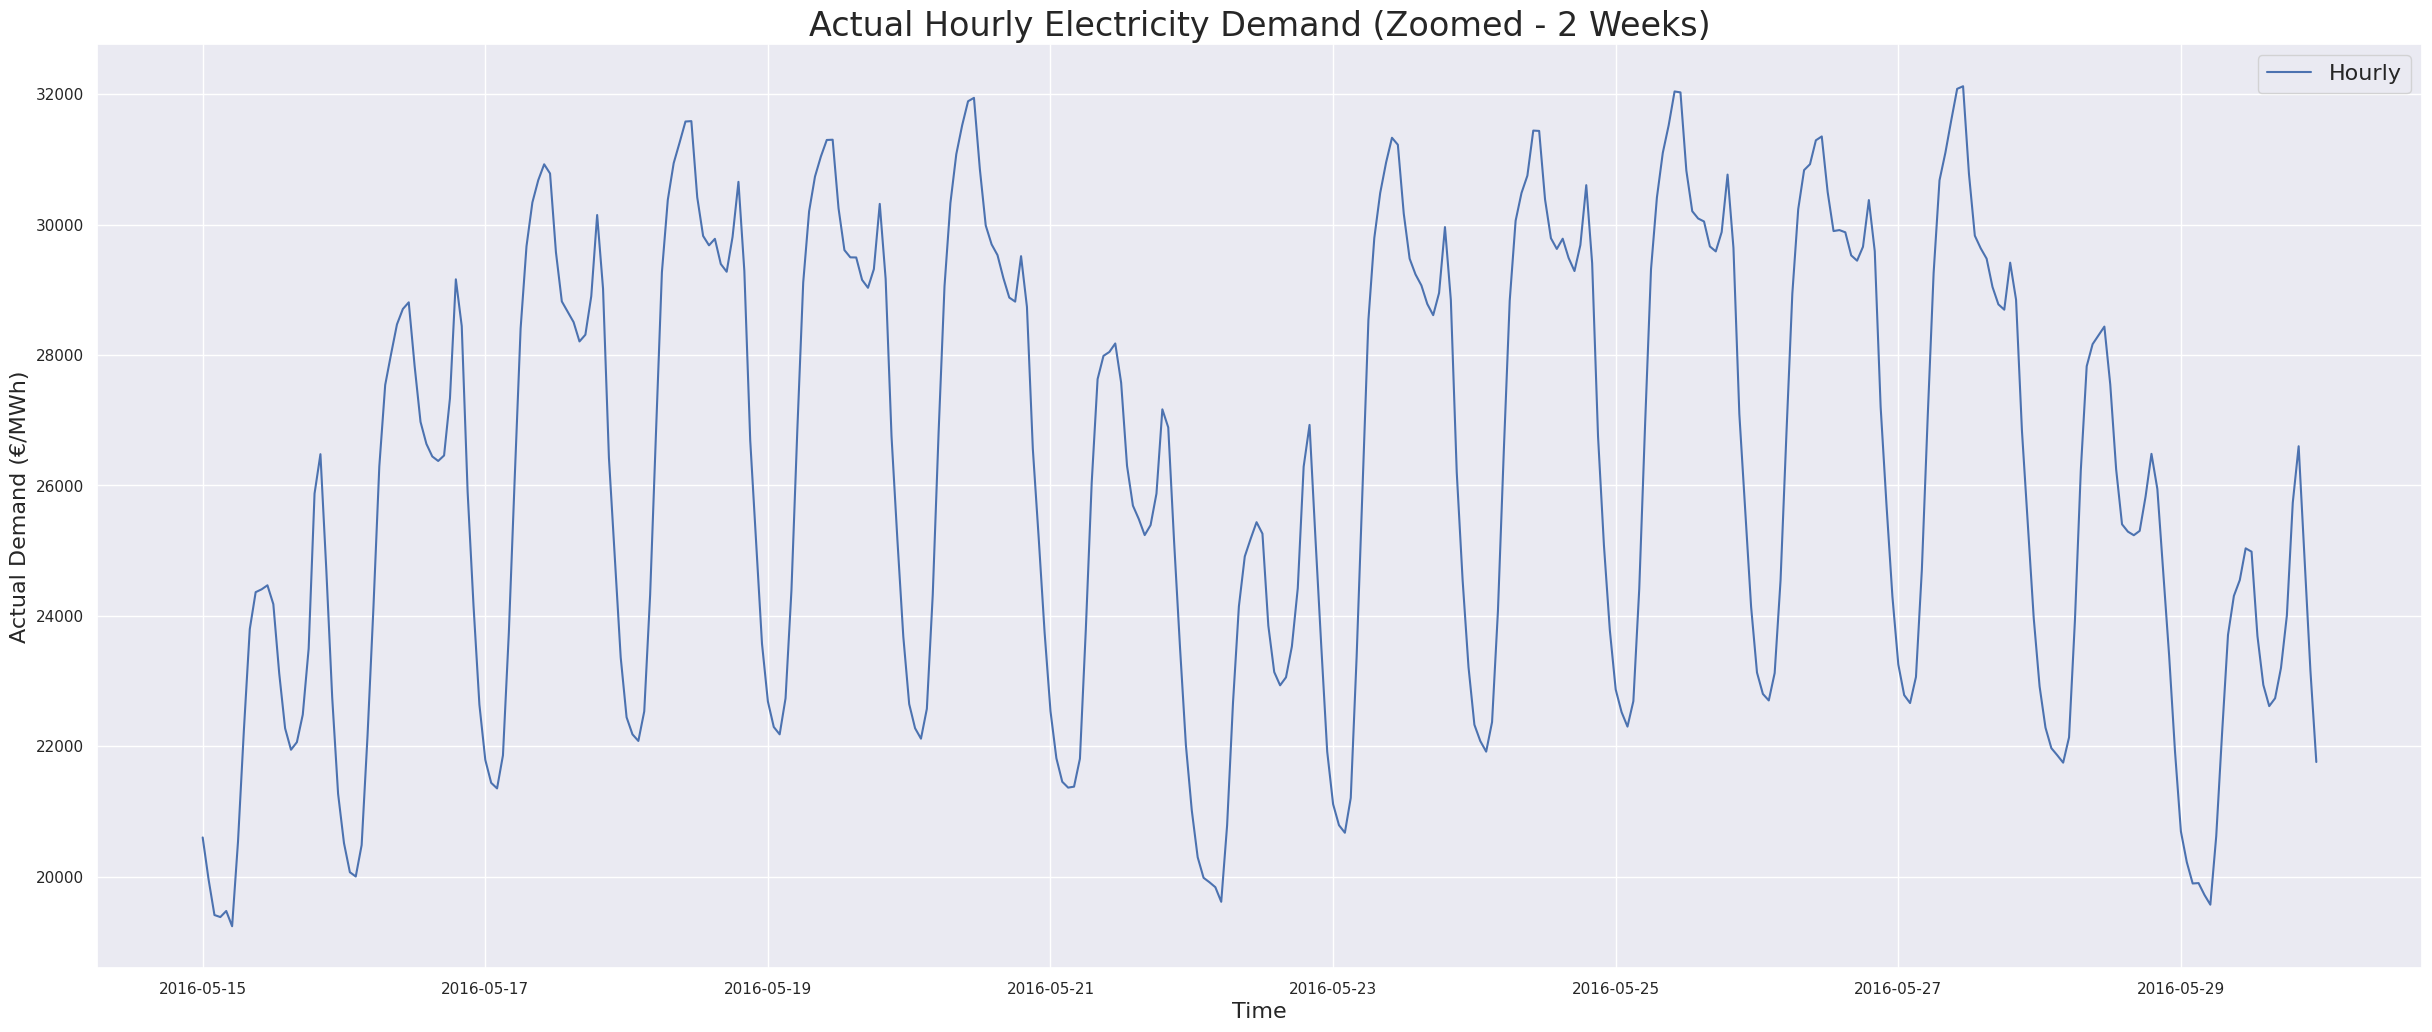

In [101]:
# Plot the actual electricity demand at a daily/weekly scale

ax = plot_series(df_filled, 'total load actual', label='Hourly', ylabel='Actual Demand (€/MWh)',
                 start=1 + 24* 500, end=1 + 24* 515,
                 title='Actual Hourly Electricity Demand (Zoomed - 2 Weeks)')
plt.show()

In the figure above, we have plotted that actual hourly electricity demand from 15/05/2016 (Sunday) at 00:00 up to 29/05/2016 (Sunday) at 23:00, i.e. two weeks of data. We can observe that there are many patterns and periodicities, such as:
- A periodicity from week to week, as the electricity price tends to be higher during business days and lower during weekends and especially during sundays.
- An intradyay periodicity, as the price is higher during the day and lower during the night.
- A periodicity within the business hours, as in some cases the electricity price drops for a few hours, which is probably due to "siesta", the traditional lunch break between 01:30PM and 04:30PM, as Spain does not strictly follow the 9AM-5PM business day.

Later on, we will make sure that we will generate features which contain these kinds of information.

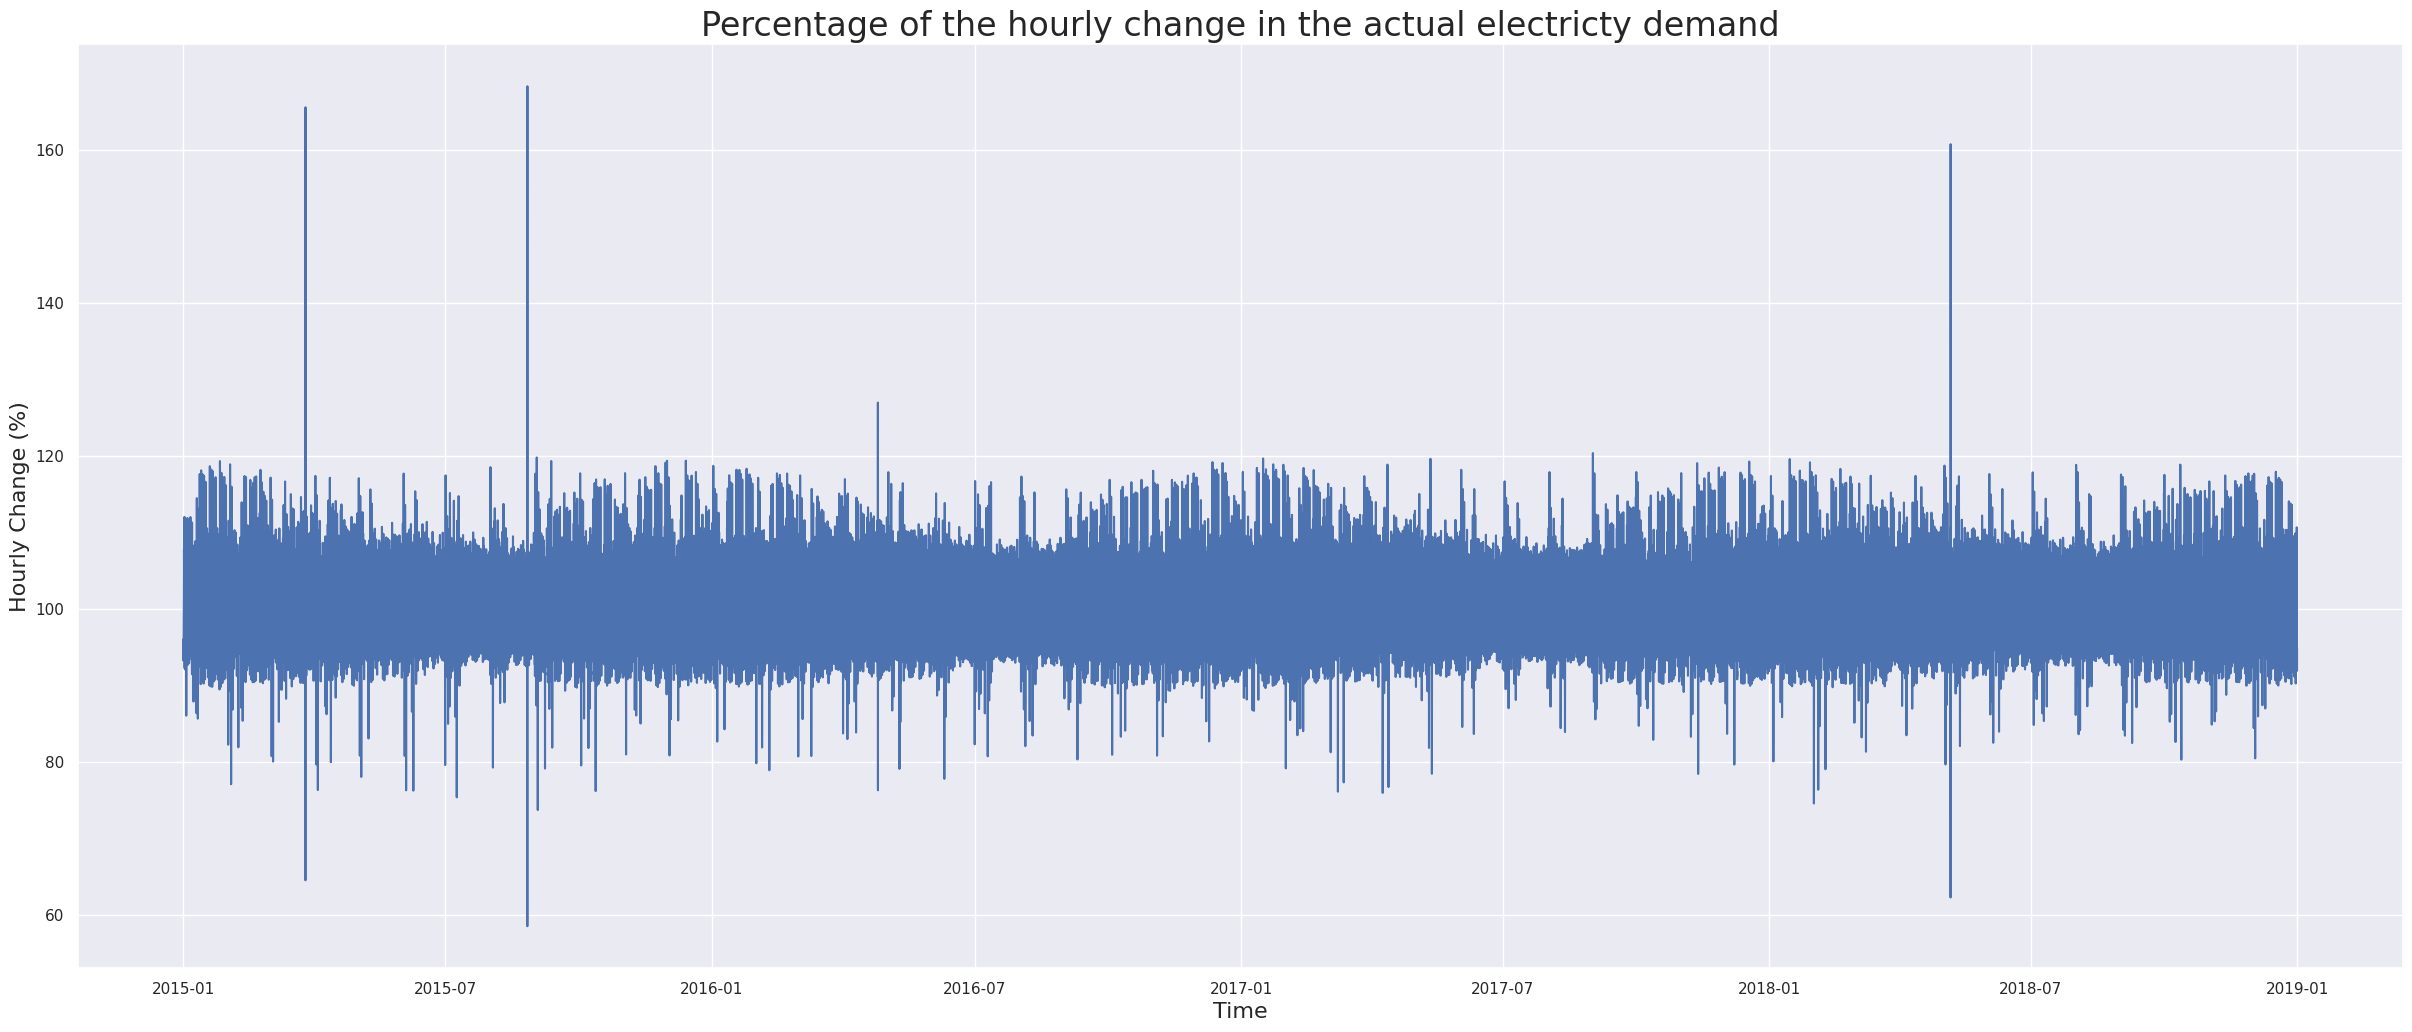

In [102]:
# Plot the percentage of the hourly change in the actual electricity demand

change = df_filled['total load actual'].div(df_filled['total load actual'].shift(1)).mul(100)
ax = plot_series(series=change, ylabel='Hourly Change (%)',
                 title='Percentage of the hourly change in the actual electricty demand')
plt.show()

From the figure above, we can see that the change in the actual demand from hour to hour is in most of the cases between -20% (actual price * 0.80) and +20% (actual price * 1.20). However, there are also very few outliers which show that the demand drops (-60%) or rises (> +60%) suddenly.

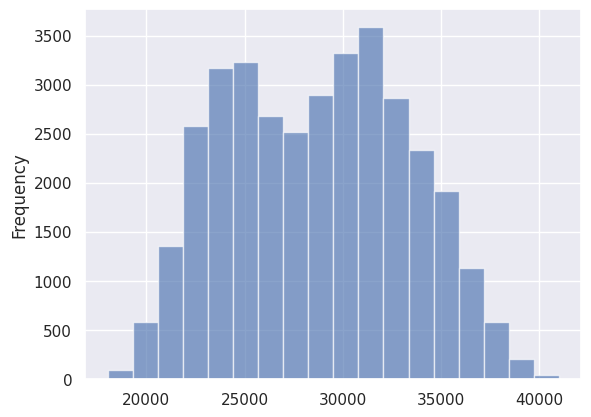

In [103]:
# Plot the histogram of the actual electricity load

ax = df_filled['total load actual'].plot.hist(bins=18, alpha=0.65)

In the figure above, we can see that the actual energy demand roughly follows a bimodal distribution and thus, should be transformed to a normal distribution. We also have to make sure that the time series does not require any other kinds of transformations. More specifically, we will check whether the time series of energy price is stationary, after visualizing its decomposed component time-series.
We see that there also some outliers (values less than 20000 and more than 40000).

Decomposition and stationarity tests

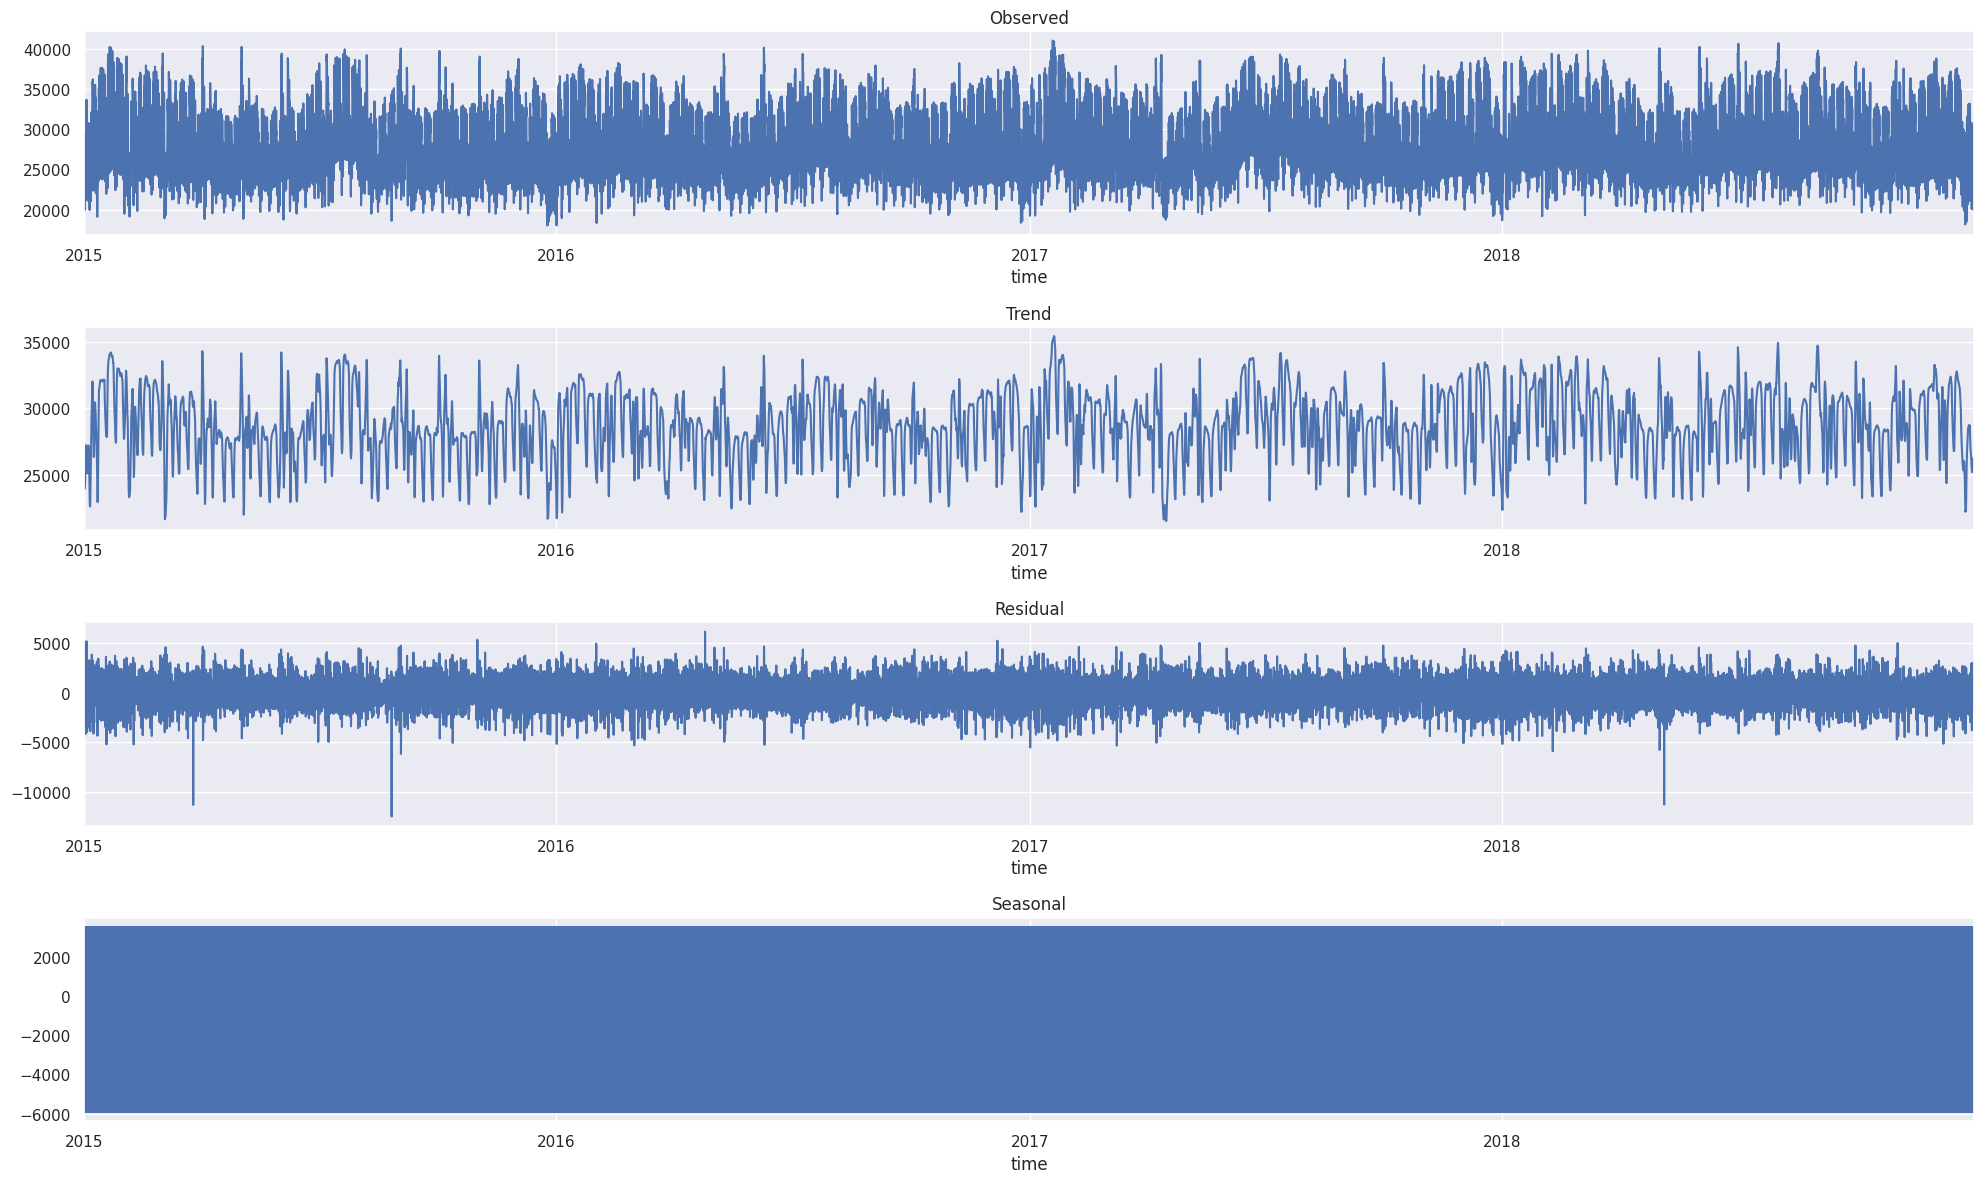

In [104]:
# Decompose the electricity demand time series

res = sm.tsa.seasonal_decompose(df_filled['total load actual'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

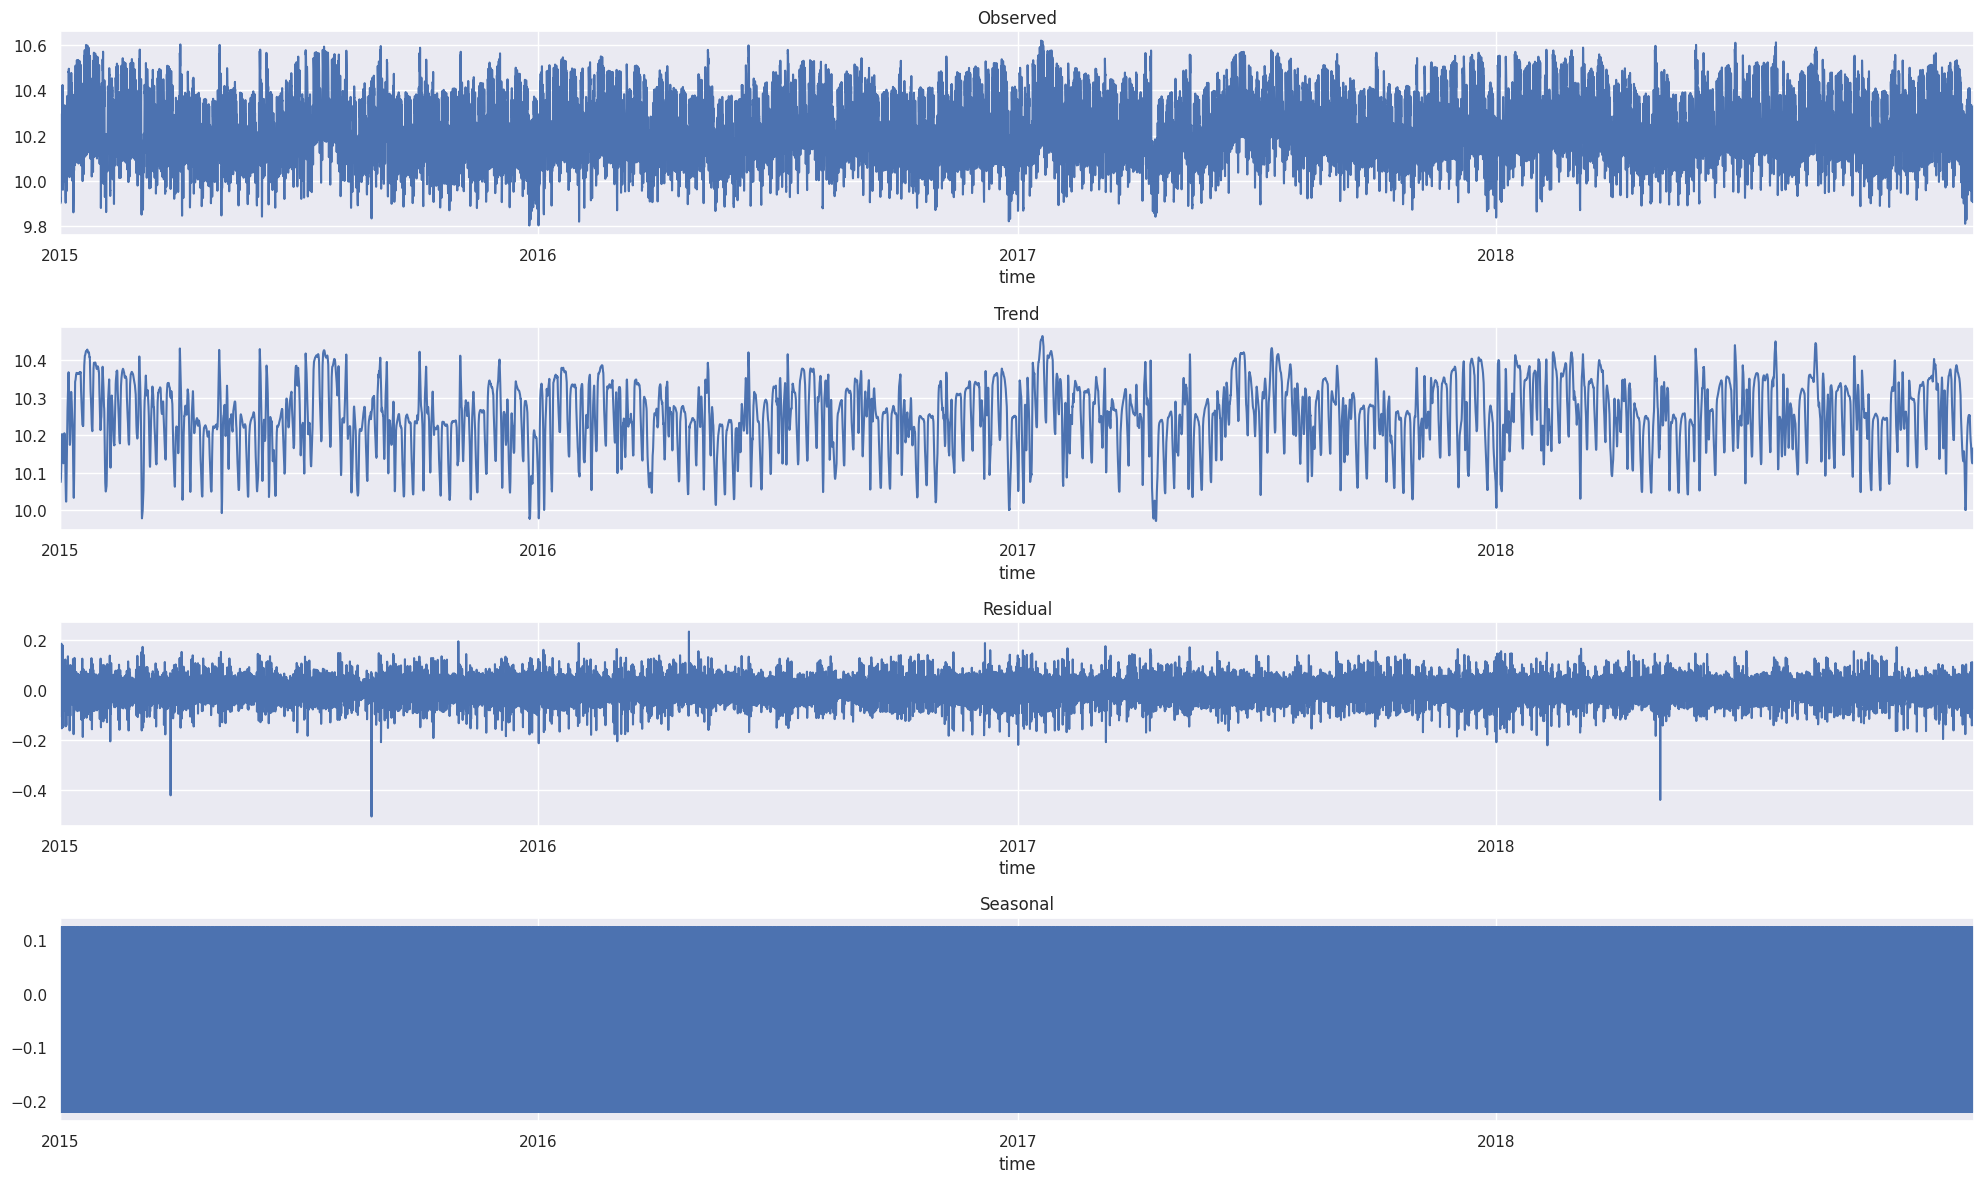

In [105]:
# Decompose the log electricity load time-series

res = sm.tsa.seasonal_decompose(np.log(df_filled['total load actual']), model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 12))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

The **Augmented Dickey-Fuller (ADF) test**, a type of unit root test, determines how strongly a time series is defined by a trend. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: There is a unit root in the time series, i.e. the series is autocorrelated with (r=1), a time dependent structure and thus, is not stationary.
- **Alternate Hypothesis** $H_{1}$: The time series has no unit root and is either stationary or can be made stationary using differencing.

In [106]:
y = df_filled['total load actual']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -21.420316
p-value: 0.000000
#Lags used: 52
Critical Value (1%): -3.430537
Critical Value (5%): -2.861623
Critical Value (10%): -2.566814


The ADF statistic (-21.420316) is less than the critical value at 1% (-3.430537) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is either stationary or could be made stationary with 1st order differencing (difference-stationary).

The **Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test**, follows the opposite logic from Augmented Dickey-Fuller test and checks for  stationarity. Its hypotheses are the following:
- **Null Hypothesis** $H_{0}$: The time series is level, i.e. it is stationary around a constant.
- **Alternate Hypothesis** $H_{1}$: There is a unit root in the time series and thus it not stationary.

In [107]:
kpss_test = kpss(y, regression='c') #, lags='legacy'
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

KPSS Statistic: 0.869660
p-value: 0.010000
#Lags used: 70
Critical Value (10%): 0.347000
Critical Value (5%): 0.463000
Critical Value (2.5%): 0.574000
Critical Value (1%): 0.739000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




The KPSS statistic (0.86966) is higher than the critical value at 1% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that the time series is stationary or stationary around a constant.

Both tests concluded that the electricity load time series is stationary, while it is also true that deep neural networks can handle such properties in a more forgiving way compared to ARIMA models.

### Autocorrelation, partial autocorrelation and cross-correlation

Σχόλιο: Μπορώ να χρησιμοποιήσω τη μέθοδο συσχέτισης Pearson ενώ η κατανομή του load είναι bimodal?

We can calculate the correlation for time series observations with observations with previous time steps. This process is called autocorrelation or serial correlation.

We also calculate the correlation . This procces is called partial correlation.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



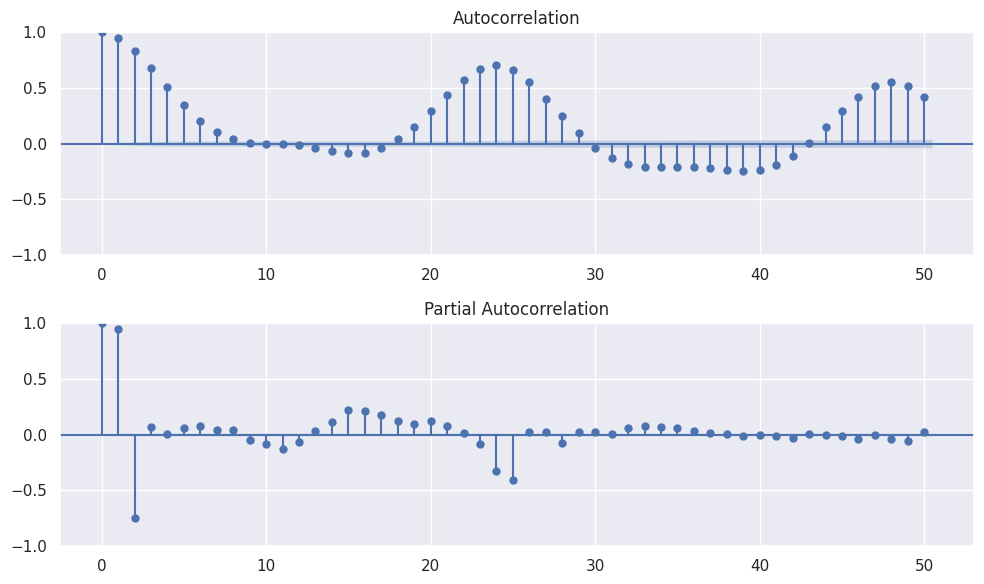

In [108]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(df_filled['total load actual'], lags=50, ax=ax1)
plot_pacf(df_filled['total load actual'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

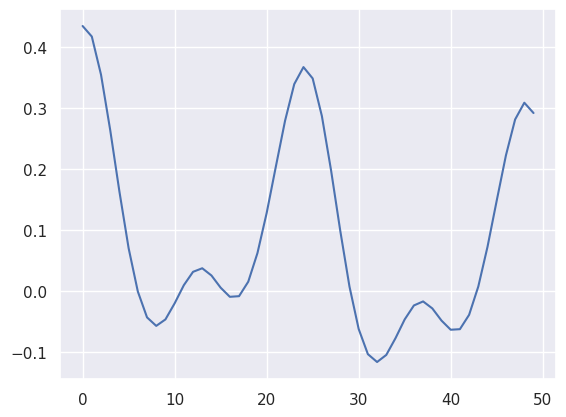

In [109]:
cross_corr = ccf(df_filled['total load actual'], df_filled['price actual'])
plt.plot(cross_corr[0:50])
plt.show()

For simplicity, we will just work with the correlations between the electricity load and the other features at each given hour.

In [110]:
# Find the correlations between the electricity load and the rest of the features

correlations = df_filled.corr(method='pearson')
print(correlations['total load actual'].sort_values(ascending=False).to_string())

total load actual                              1.000000
total load forecast                            0.995096
generation all                                 0.829972
generation fossil gas                          0.548986
generation fossil oil                          0.496139
generation hydro water reservoir               0.479491
price day ahead                                0.474273
price actual                                   0.435253
forecast solar day ahead                       0.403835
generation fossil hard coal                    0.397079
generation solar                               0.395511
generation fossil brown coal/lignite           0.280735
generation other renewable                     0.180814
generation hydro run-of-river and poundage     0.118482
generation other                               0.100666
generation nuclear                             0.086085
generation biomass                             0.083507
generation waste                               0

From the above, we can already see some very interesting correlations among the energy demand that we want to predict and the rest of the features. For example, the total generation of energy is positively correlated with the electricity demand. In contrast, the amount of storage energy consumed through hydroelectric pumping is negatively correlated with the energy demand.

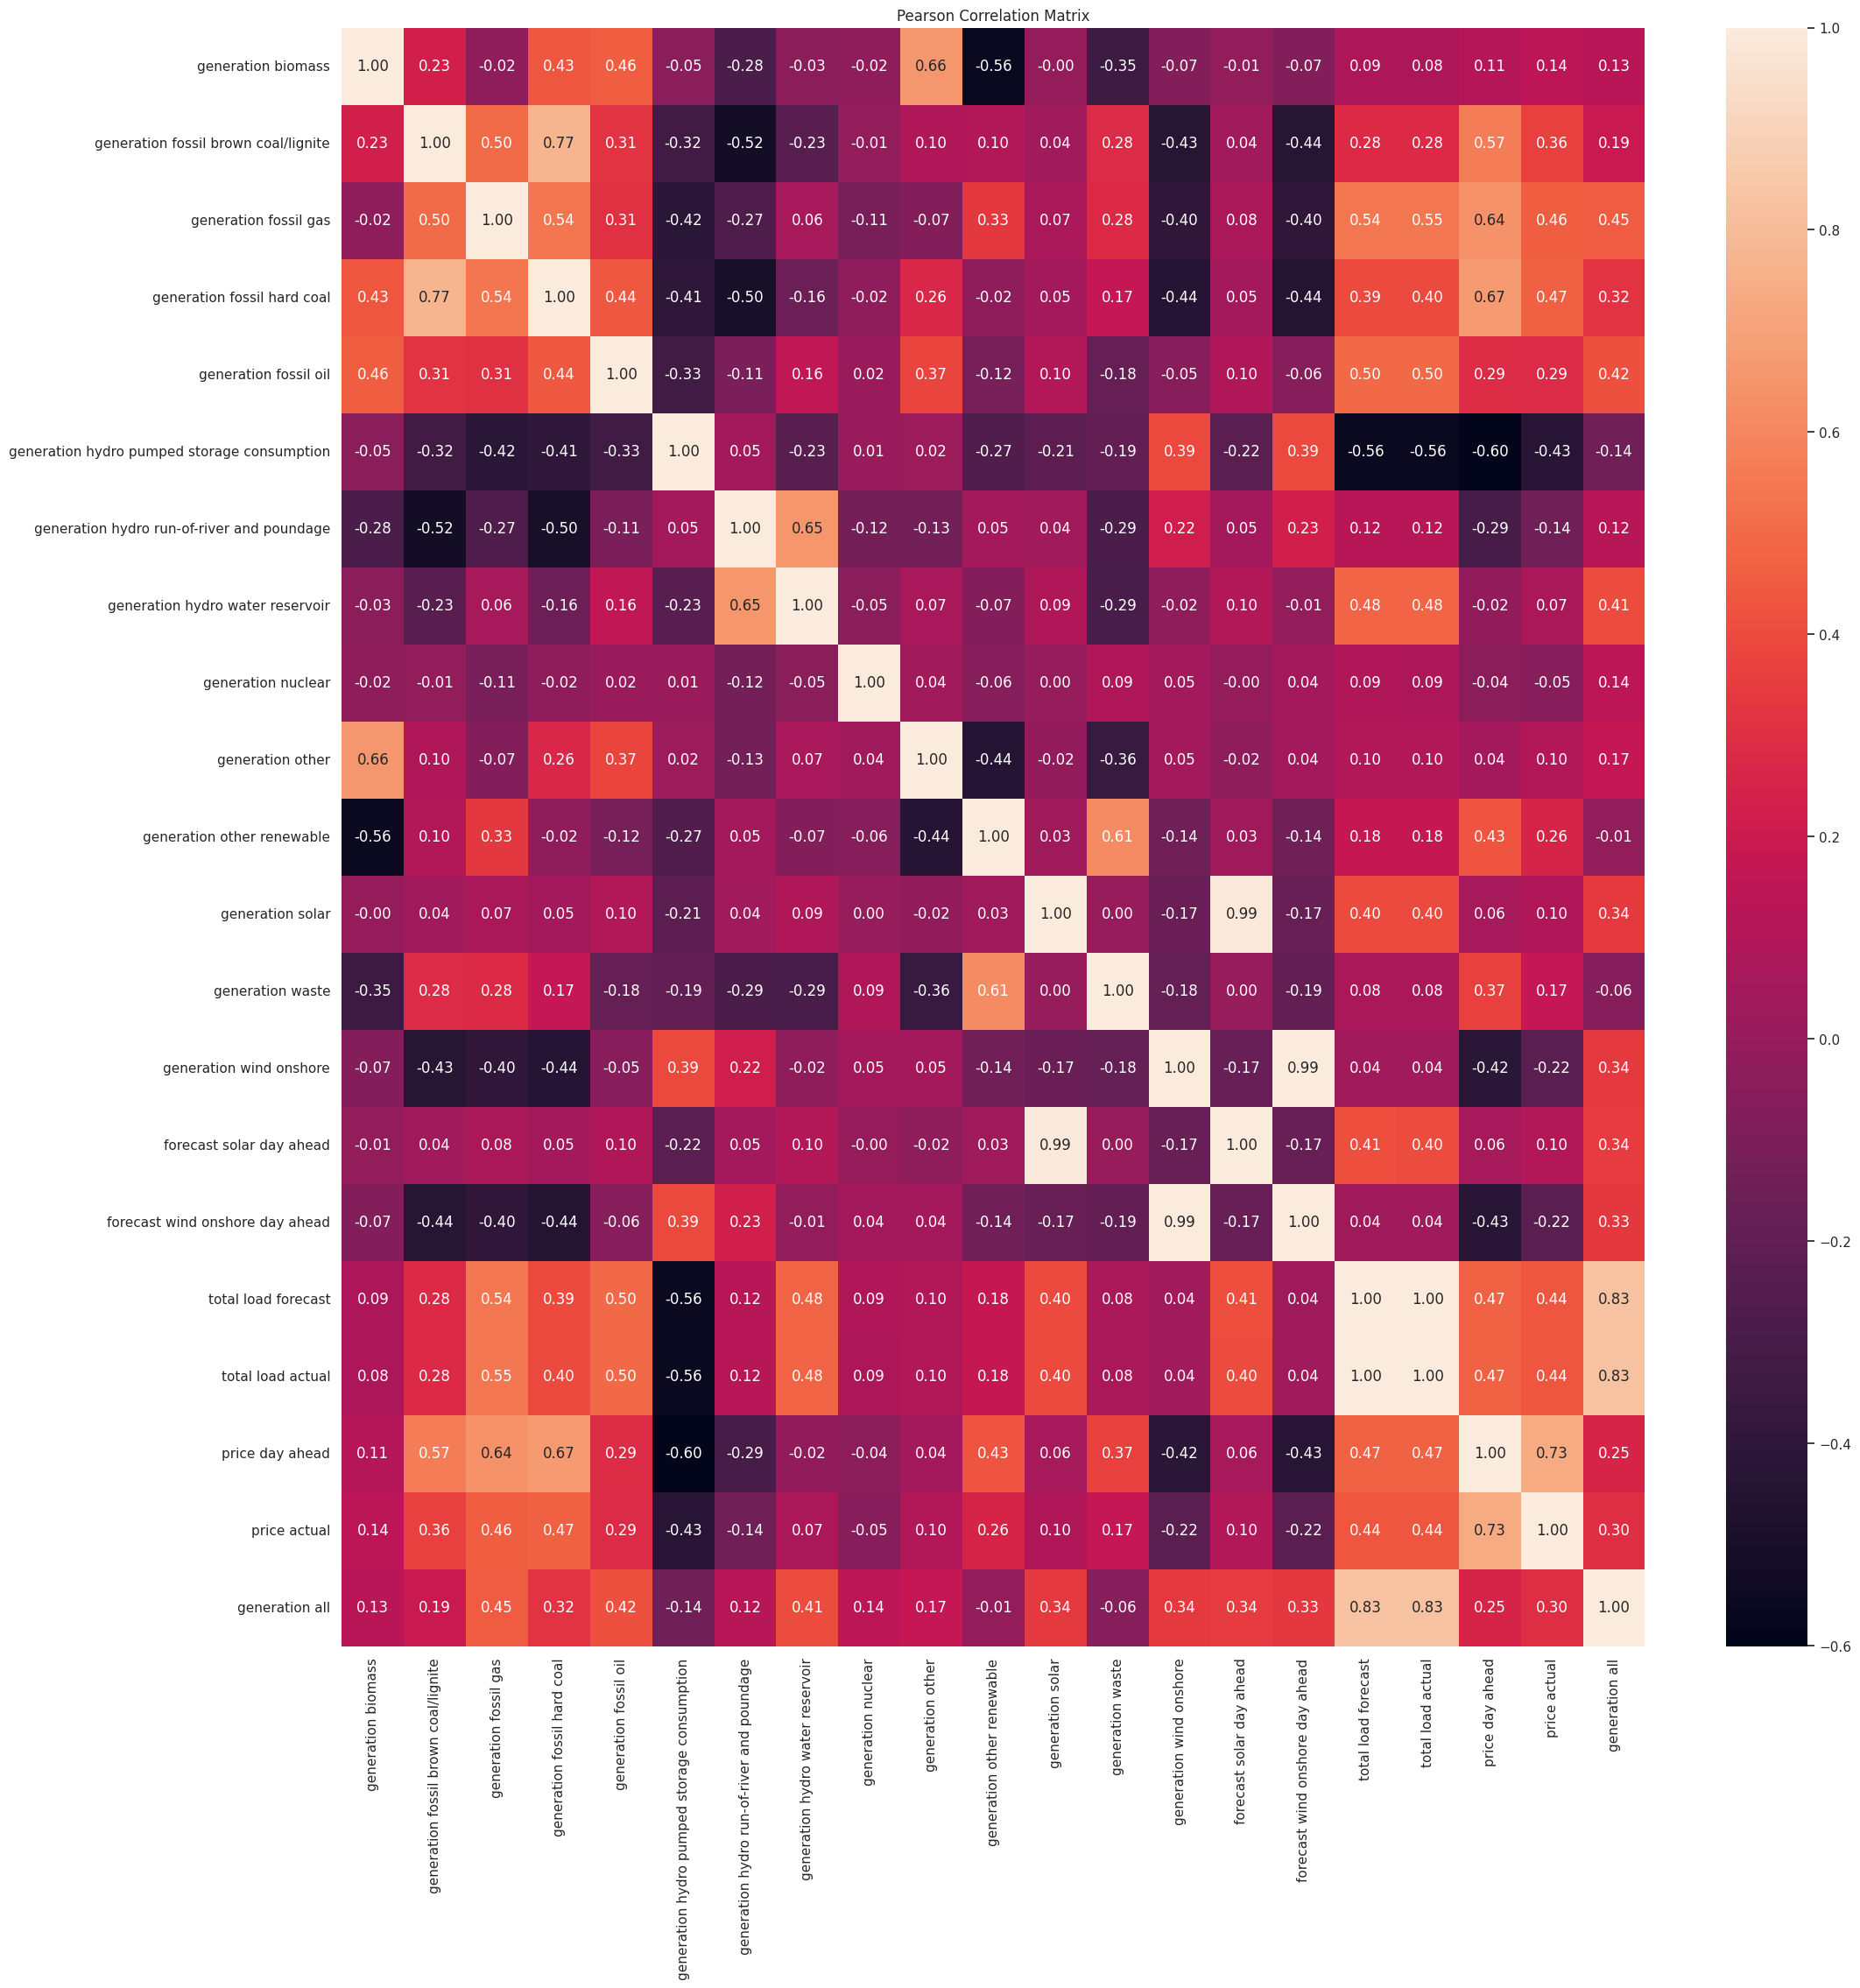

In [111]:
# Plot Pearson correlation matrix

correlations = df_filled.corr(method='pearson')
fig = plt.figure(figsize=(24, 24))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

While we cannot make a lot out of the above correlation matrix, we can observe that there quite a lot of features that are highly correlated with each other.

In [112]:
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768831
generation fossil hard coal           generation fossil brown coal/lignite    0.768831
generation solar                      forecast solar day ahead                0.993244
generation wind onshore               forecast wind onshore day ahead         0.994457
forecast solar day ahead              generation solar                        0.993244
forecast wind onshore day ahead       generation wind onshore                 0.994457
total load forecast                   total load actual                       0.995096
                                      generation all                          0.826242
total load actual                     total load forecast                     0.995096
                                      generation all                          0.829972
generation all                        total load forecast                     0.826242
                                      total

What we can observe, is that apart from the forecasted features, the only features that are highly correlated are the total load and the total generation as well as the generation from hard coal and brown coal.

## Feature Engineering

This selection is useful for someone who wants to perform multivariate time series forecasting.

### Feature Generation

The generation from hard coal and brown coal are highly correlated, so we concatenate them into one column.

In [113]:
# concat coal columns (they have high correlation)
df_filled['generation coal all'] = df_filled['generation fossil hard coal'] + df_filled['generation fossil brown coal/lignite']
df_filled = df_filled.drop(['generation fossil hard coal', 'generation fossil brown coal/lignite'], axis = 1)

## Data Split

We split the data so that 90% of it is the train set and the rest 10% is the test set.

The data needs to be split in chronological order for the models to take into account the historical data to predict the next data point accurately.

In [114]:
num_train_samples = int(0.9 * len(df_filled))
print(num_train_samples)
num_test_samples = len(df_filled) - num_train_samples
print(num_test_samples)

31557
3507


### Normalization / Scaling:

In [115]:
df_scaled = df_filled

In [116]:
mean = df_filled[:num_train_samples].mean(axis=0)
print(mean)
df_filled -= mean
std = df_filled[:num_train_samples].std(axis=0)
print(std)
df_filled /= std

generation biomass                               388.421586
generation fossil gas                           5546.877888
generation fossil oil                            300.118215
generation hydro pumped storage consumption      492.316760
generation hydro run-of-river and poundage       965.773410
generation hydro water reservoir                2630.222344
generation nuclear                              6267.591913
generation other                                  60.637022
generation other renewable                        84.314383
generation solar                                1460.654482
generation waste                                 265.904712
generation wind onshore                         5472.582612
forecast solar day ahead                        1464.906233
forecast wind onshore day ahead                 5475.392338
total load forecast                            28693.164591
total load actual                              28674.857765
price day ahead                         

### Windowing

Time Series Data needs to be split in sliding windows in order to permit to the models to know to which historical values to focus on to compute the next value.

For each value that needs to be predicted, the model needs to take as input the previous 24 hours (24 data points).

So, we have to create sliding windows of samples and target sets (24 samples and one target in each window).

We also split the train and test sets into batches of 256 values each. The batches are useful for the models to compute results in small parts of the dataset so that the prediction can be more accurate.

In [117]:
sequence_length = 24
delay = sequence_length -1
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    df_filled['total load actual'][:-delay],
    df_filled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df_filled['total load actual'][:-delay],
    df_filled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples)

In [118]:
for sample, target in train_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

train_ds = train_dataset.unbatch()
samples = np.array(list(train_ds.map(lambda x, y: x)))
targets = np.array(list(train_ds.map(lambda x, y: y)))

samples shape: (256, 24)
targets shape: (256,)


In [119]:
for sample, target in test_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

test_ds = test_dataset.unbatch()
test_samples = np.array(list(test_ds.map(lambda x, y: x)))
test_targets = np.array(list(test_ds.map(lambda x, y: y)))

samples shape: (256, 24)
targets shape: (256,)


## Models

### Common Functions

Training Loss and Metrics Visualization method (this function is used after every model to observe its learning curve):

In [120]:
def plot_model_rmse_and_loss(history):

    # Evaluate train accuracies and losses

    train_rmse = history.history['root_mean_squared_error']

    train_loss = history.history['loss']

    # Visualize epochs vs. train accuracies and losses

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.legend()
    plt.title('Epochs vs. Training RMSE')

    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.legend()
    plt.title('Epochs vs. Training Loss')

    plt.show()

Training Function:

With compile fuction we configure the model with some parameters (optimizer to adjust model weights and minimize the loss, loss to monitor the performance of the optimizer, metrics to monitor the accuracy of the model) to make the training process easier.

Then, with fit function we insert our train data to the model and it starts "learning". We also add an early stopping parameter (stops training in epoch if the loss does not improve within 50 batches iterations) and a checkpoint parameter to save the best model with minimal error.

In [121]:
def train(model, dataset, lr, checkpoint, num_epochs, num_batch):
  checkpoint_dir = checkpoint

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='mean_squared_error', metrics = [tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  # Stop training if error does not improve within 50 iterations
  early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

  # Save the best model ... with minimal error
  filepath = checkpoint_dir+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')


  history = model.fit(dataset,epochs=num_epochs,batch_size=num_batch, verbose=1, callbacks = [early_stopping_monitor, checkpoint])

  #print('loss: {0}, rmse: {1}, r2: {2}, mae: {3}, mape: {4}'.format(history.history['loss'][-1], history.history['root_mean_squared_error'][-1]), history.history['r_squared'][-1], history.history['mean_absolute_error'][-1], history.history['mean_absolute_percentage_error'][-1])
  plot_model_rmse_and_loss(history)
  return(model, history)

Testing Function:

This method predicts the next hour value in the test data and prints the metrics results. This step is useful to evaluate the model's performance to unseen data.

The metrics are the following:
1. **Mean Squared Error**: Finds the average of the squared difference between the target value and the value predicted by the regression model. It’s fundamentally more prone to outliers than other metrics and it penalizes even small errors by squaring them.
2. **R^2 Score**
3. **Root Mean Squared Error**
4. **Mean Absolute Error**: Finds the average of the difference between the ground truth and the predicted values. It doesn’t exaggerate errors.
5. **Mean Absolute Percentage Error**

In [122]:
def test(model, data):

  results ={}

  results['predictions'] = model.predict(data)
  print(len(results['predictions']))
  #results['predictions'] = pd.DataFrame(results['predictions'])
  #results['predictions'].index = pd.RangeIndex(df.index[num_train_samples:][0],df.index[num_train_samples:][len(results['predictions'])])
  test_data = data.unbatch()
  test_data = np.array(list(test_data.map(lambda x, y: y)))
  test_data = test_data.reshape(len(test_data),1)
  test_data = tf.convert_to_tensor(test_data)
  pred = tf.convert_to_tensor(results['predictions'])

  loss = tf.keras.metrics.MeanSquaredError()
  loss.update_state(test_data, pred)
  results['loss'] = float(loss.result())
  r2 = tfa.metrics.RSquare()
  r2.update_state(test_data, pred)
  results['r2'] = float(r2.result())
  rmse = tf.keras.metrics.RootMeanSquaredError()
  rmse.update_state(test_data, pred)
  results['rmse'] = float(rmse.result())
  mae = tf.keras.metrics.MeanAbsoluteError()
  mae.update_state(test_data, pred)
  results['mae'] = float(mae.result())
  mape = tf.keras.metrics.MeanAbsolutePercentageError()
  mape.update_state(test_data, pred)
  results['mape'] = float(mape.result())

  print('loss: {0}, rmse: {1}, r2: {2}, mae: {3}, mape: {4}'.format(results['loss'], results['rmse'],
                                                             results['r2'], results['mae'], results['mape']))
  return results

### Linear Model Baseline (Linear Regression)

We create a linear model. It contains a normalization layer and a single perceptron (dense layer).

The dense layer performs a calculation of in the form of: y=w*x+b.

First, we build the structure of the model.

In [123]:
inputs = keras.Input(shape=(sequence_length,))
print(inputs.shape)
x = keras.layers.Normalization()(inputs)
outputs = keras.layers.Dense(units=1)(x)


linear_model = keras.Model(inputs, outputs)

linear_model.summary()

(None, 24)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 24)]              0         
                                                                 
 normalization_2 (Normalizat  (None, 24)               49        
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 1)                 25        
                                                                 
Total params: 74
Trainable params: 25
Non-trainable params: 49
_________________________________________________________________


Then, we train the model to learn the training data.

Epoch 1/50
122/124 [============================>.] - ETA: 0s - loss: 0.7644 - r_square: 0.2335 - root_mean_squared_error: 0.8743 - mean_absolute_error: 0.7026 - mean_absolute_percentage_error: 391.8036


Epoch 1: loss improved from inf to 0.76006, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 35ms/step - loss: 0.7601 - r_square: 0.2396 - root_mean_squared_error: 0.8718 - mean_absolute_error: 0.7003 - mean_absolute_percentage_error: 389.5908
Epoch 2/50
122/124 [============================>.] - ETA: 0s - loss: 0.1500 - r_square: 0.8496 - root_mean_squared_error: 0.3873 - mean_absolute_error: 0.3054 - mean_absolute_percentage_error: 161.6094


Epoch 2: loss improved from 0.76006 to 0.14945, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 45ms/step - loss: 0.1495 - r_square: 0.8505 - root_mean_squared_error: 0.3866 - mean_absolute_error: 0.3047 - mean_absolute_percentage_error: 160.7675
Epoch 3/50
122/124 [============================>.] - ETA: 0s - loss: 0.0677 - r_square: 0.9321 - root_mean_squared_error: 0.2602 - mean_absolute_error: 0.2026 - mean_absolute_percentage_error: 107.8514


Epoch 3: loss improved from 0.14945 to 0.06754, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0675 - r_square: 0.9324 - root_mean_squared_error: 0.2599 - mean_absolute_error: 0.2024 - mean_absolute_percentage_error: 107.3746
Epoch 4/50
122/124 [============================>.] - ETA: 0s - loss: 0.0430 - r_square: 0.9569 - root_mean_squared_error: 0.2073 - mean_absolute_error: 0.1623 - mean_absolute_percentage_error: 86.8676


Epoch 4: loss improved from 0.06754 to 0.04285, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 46ms/step - loss: 0.0429 - r_square: 0.9571 - root_mean_squared_error: 0.2070 - mean_absolute_error: 0.1620 - mean_absolute_percentage_error: 86.5063
Epoch 5/50
123/124 [============================>.] - ETA: 0s - loss: 0.0299 - r_square: 0.9701 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1359 - mean_absolute_percentage_error: 73.5228


Epoch 5: loss improved from 0.04285 to 0.02992, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 35ms/step - loss: 0.0299 - r_square: 0.9701 - root_mean_squared_error: 0.1730 - mean_absolute_error: 0.1358 - mean_absolute_percentage_error: 73.4990
Epoch 6/50
122/124 [============================>.] - ETA: 0s - loss: 0.0222 - r_square: 0.9778 - root_mean_squared_error: 0.1489 - mean_absolute_error: 0.1170 - mean_absolute_percentage_error: 64.3988


Epoch 6: loss improved from 0.02992 to 0.02209, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 35ms/step - loss: 0.0221 - r_square: 0.9779 - root_mean_squared_error: 0.1486 - mean_absolute_error: 0.1168 - mean_absolute_percentage_error: 64.1408
Epoch 7/50
122/124 [============================>.] - ETA: 0s - loss: 0.0174 - r_square: 0.9825 - root_mean_squared_error: 0.1320 - mean_absolute_error: 0.1035 - mean_absolute_percentage_error: 57.4525


Epoch 7: loss improved from 0.02209 to 0.01736, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 43ms/step - loss: 0.0174 - r_square: 0.9826 - root_mean_squared_error: 0.1318 - mean_absolute_error: 0.1033 - mean_absolute_percentage_error: 57.2283
Epoch 8/50
122/124 [============================>.] - ETA: 0s - loss: 0.0144 - r_square: 0.9855 - root_mean_squared_error: 0.1202 - mean_absolute_error: 0.0940 - mean_absolute_percentage_error: 52.5329


Epoch 8: loss improved from 0.01736 to 0.01440, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0144 - r_square: 0.9856 - root_mean_squared_error: 0.1200 - mean_absolute_error: 0.0938 - mean_absolute_percentage_error: 52.3404
Epoch 9/50
123/124 [============================>.] - ETA: 0s - loss: 0.0124 - r_square: 0.9876 - root_mean_squared_error: 0.1112 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 48.6562


Epoch 9: loss improved from 0.01440 to 0.01237, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0124 - r_square: 0.9876 - root_mean_squared_error: 0.1112 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 48.6465
Epoch 10/50
122/124 [============================>.] - ETA: 0s - loss: 0.0108 - r_square: 0.9891 - root_mean_squared_error: 0.1042 - mean_absolute_error: 0.0811 - mean_absolute_percentage_error: 45.6160


Epoch 10: loss improved from 0.01237 to 0.01081, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 42ms/step - loss: 0.0108 - r_square: 0.9892 - root_mean_squared_error: 0.1040 - mean_absolute_error: 0.0809 - mean_absolute_percentage_error: 45.4695
Epoch 11/50
122/124 [============================>.] - ETA: 0s - loss: 0.0095 - r_square: 0.9904 - root_mean_squared_error: 0.0977 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 42.7114


Epoch 11: loss improved from 0.01081 to 0.00951, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 42ms/step - loss: 0.0095 - r_square: 0.9905 - root_mean_squared_error: 0.0975 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 42.5832
Epoch 12/50
124/124 [==============================] - ETA: 0s - loss: 0.0084 - r_square: 0.9916 - root_mean_squared_error: 0.0916 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 39.9233


Epoch 12: loss improved from 0.00951 to 0.00839, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.0084 - r_square: 0.9916 - root_mean_squared_error: 0.0916 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 39.9233
Epoch 13/50
123/124 [============================>.] - ETA: 0s - loss: 0.0074 - r_square: 0.9926 - root_mean_squared_error: 0.0861 - mean_absolute_error: 0.0662 - mean_absolute_percentage_error: 37.4279


Epoch 13: loss improved from 0.00839 to 0.00741, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.0074 - r_square: 0.9926 - root_mean_squared_error: 0.0861 - mean_absolute_error: 0.0662 - mean_absolute_percentage_error: 37.4175
Epoch 14/50
124/124 [==============================] - ETA: 0s - loss: 0.0066 - r_square: 0.9934 - root_mean_squared_error: 0.0810 - mean_absolute_error: 0.0619 - mean_absolute_percentage_error: 35.0646


Epoch 14: loss improved from 0.00741 to 0.00655, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 40ms/step - loss: 0.0066 - r_square: 0.9934 - root_mean_squared_error: 0.0810 - mean_absolute_error: 0.0619 - mean_absolute_percentage_error: 35.0646
Epoch 15/50
122/124 [============================>.] - ETA: 0s - loss: 0.0058 - r_square: 0.9941 - root_mean_squared_error: 0.0764 - mean_absolute_error: 0.0580 - mean_absolute_percentage_error: 32.9283


Epoch 15: loss improved from 0.00655 to 0.00581, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 39ms/step - loss: 0.0058 - r_square: 0.9942 - root_mean_squared_error: 0.0762 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 32.8550
Epoch 16/50
123/124 [============================>.] - ETA: 0s - loss: 0.0052 - r_square: 0.9948 - root_mean_squared_error: 0.0719 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 30.8009


Epoch 16: loss improved from 0.00581 to 0.00517, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0052 - r_square: 0.9948 - root_mean_squared_error: 0.0719 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 30.7886
Epoch 17/50
124/124 [==============================] - ETA: 0s - loss: 0.0046 - r_square: 0.9954 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 28.8785


Epoch 17: loss improved from 0.00517 to 0.00463, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.0046 - r_square: 0.9954 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0509 - mean_absolute_percentage_error: 28.8785
Epoch 18/50
123/124 [============================>.] - ETA: 0s - loss: 0.0042 - r_square: 0.9958 - root_mean_squared_error: 0.0645 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 27.1394


Epoch 18: loss improved from 0.00463 to 0.00416, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.0042 - r_square: 0.9958 - root_mean_squared_error: 0.0645 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 27.1260
Epoch 19/50
123/124 [============================>.] - ETA: 0s - loss: 0.0038 - r_square: 0.9962 - root_mean_squared_error: 0.0613 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 25.5324


Epoch 19: loss improved from 0.00416 to 0.00376, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 45ms/step - loss: 0.0038 - r_square: 0.9962 - root_mean_squared_error: 0.0613 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 25.5185
Epoch 20/50
122/124 [============================>.] - ETA: 0s - loss: 0.0034 - r_square: 0.9966 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 24.1084


Epoch 20: loss improved from 0.00376 to 0.00342, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 35ms/step - loss: 0.0034 - r_square: 0.9966 - root_mean_squared_error: 0.0585 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 24.0722
Epoch 21/50
123/124 [============================>.] - ETA: 0s - loss: 0.0031 - r_square: 0.9969 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 22.7899


Epoch 21: loss improved from 0.00342 to 0.00312, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 33ms/step - loss: 0.0031 - r_square: 0.9969 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 22.7751
Epoch 22/50
123/124 [============================>.] - ETA: 0s - loss: 0.0029 - r_square: 0.9971 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 21.6492


Epoch 22: loss improved from 0.00312 to 0.00286, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 46ms/step - loss: 0.0029 - r_square: 0.9971 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 21.6345
Epoch 23/50
122/124 [============================>.] - ETA: 0s - loss: 0.0026 - r_square: 0.9973 - root_mean_squared_error: 0.0514 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 20.6388


Epoch 23: loss improved from 0.00286 to 0.00263, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0026 - r_square: 0.9974 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 20.6123
Epoch 24/50
123/124 [============================>.] - ETA: 0s - loss: 0.0024 - r_square: 0.9976 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 19.7017


Epoch 24: loss improved from 0.00263 to 0.00243, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 46ms/step - loss: 0.0024 - r_square: 0.9976 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 19.6894
Epoch 25/50
123/124 [============================>.] - ETA: 0s - loss: 0.0022 - r_square: 0.9978 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 18.8355


Epoch 25: loss improved from 0.00243 to 0.00224, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0022 - r_square: 0.9978 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 18.8244
Epoch 26/50
123/124 [============================>.] - ETA: 0s - loss: 0.0021 - r_square: 0.9979 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 18.0115


Epoch 26: loss improved from 0.00224 to 0.00208, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 6s 45ms/step - loss: 0.0021 - r_square: 0.9979 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 18.0013
Epoch 27/50
123/124 [============================>.] - ETA: 0s - loss: 0.0019 - r_square: 0.9981 - root_mean_squared_error: 0.0439 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 17.2248


Epoch 27: loss improved from 0.00208 to 0.00193, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0019 - r_square: 0.9981 - root_mean_squared_error: 0.0439 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 17.2155
Epoch 28/50
123/124 [============================>.] - ETA: 0s - loss: 0.0018 - r_square: 0.9982 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 16.4692


Epoch 28: loss improved from 0.00193 to 0.00178, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0018 - r_square: 0.9982 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 16.4607
Epoch 29/50
123/124 [============================>.] - ETA: 0s - loss: 0.0017 - r_square: 0.9983 - root_mean_squared_error: 0.0407 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 15.7657


Epoch 29: loss improved from 0.00178 to 0.00165, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 42ms/step - loss: 0.0017 - r_square: 0.9983 - root_mean_squared_error: 0.0407 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 15.7578
Epoch 30/50
124/124 [==============================] - ETA: 0s - loss: 0.0015 - r_square: 0.9985 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 15.0654


Epoch 30: loss improved from 0.00165 to 0.00153, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 38ms/step - loss: 0.0015 - r_square: 0.9985 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 15.0654
Epoch 31/50
122/124 [============================>.] - ETA: 0s - loss: 0.0014 - r_square: 0.9986 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 14.4010


Epoch 31: loss improved from 0.00153 to 0.00142, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 0.0014 - r_square: 0.9986 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 14.3821
Epoch 32/50
122/124 [============================>.] - ETA: 0s - loss: 0.0013 - r_square: 0.9987 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 13.7243


Epoch 32: loss improved from 0.00142 to 0.00131, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 0.0013 - r_square: 0.9987 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 13.7058
Epoch 33/50
123/124 [============================>.] - ETA: 0s - loss: 0.0012 - r_square: 0.9988 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 13.0449


Epoch 33: loss improved from 0.00131 to 0.00122, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 35ms/step - loss: 0.0012 - r_square: 0.9988 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 13.0389
Epoch 34/50
123/124 [============================>.] - ETA: 0s - loss: 0.0011 - r_square: 0.9989 - root_mean_squared_error: 0.0335 - mean_absolute_error: 0.0233 - mean_absolute_percentage_error: 12.3962


Epoch 34: loss improved from 0.00122 to 0.00112, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 43ms/step - loss: 0.0011 - r_square: 0.9989 - root_mean_squared_error: 0.0335 - mean_absolute_error: 0.0233 - mean_absolute_percentage_error: 12.3906
Epoch 35/50
123/124 [============================>.] - ETA: 0s - loss: 0.0010 - r_square: 0.9990 - root_mean_squared_error: 0.0322 - mean_absolute_error: 0.0223 - mean_absolute_percentage_error: 11.7600


Epoch 35: loss improved from 0.00112 to 0.00104, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 36ms/step - loss: 0.0010 - r_square: 0.9990 - root_mean_squared_error: 0.0322 - mean_absolute_error: 0.0223 - mean_absolute_percentage_error: 11.7548
Epoch 36/50
122/124 [============================>.] - ETA: 0s - loss: 9.5897e-04 - r_square: 0.9990 - root_mean_squared_error: 0.0310 - mean_absolute_error: 0.0214 - mean_absolute_percentage_error: 11.1518


Epoch 36: loss improved from 0.00104 to 0.00095, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 9.5412e-04 - r_square: 0.9990 - root_mean_squared_error: 0.0309 - mean_absolute_error: 0.0213 - mean_absolute_percentage_error: 11.1347
Epoch 37/50
122/124 [============================>.] - ETA: 0s - loss: 8.8175e-04 - r_square: 0.9991 - root_mean_squared_error: 0.0297 - mean_absolute_error: 0.0204 - mean_absolute_percentage_error: 10.5451


Epoch 37: loss improved from 0.00095 to 0.00088, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 8.7728e-04 - r_square: 0.9991 - root_mean_squared_error: 0.0296 - mean_absolute_error: 0.0203 - mean_absolute_percentage_error: 10.5283
Epoch 38/50
122/124 [============================>.] - ETA: 0s - loss: 8.0934e-04 - r_square: 0.9992 - root_mean_squared_error: 0.0284 - mean_absolute_error: 0.0194 - mean_absolute_percentage_error: 9.9500


Epoch 38: loss improved from 0.00088 to 0.00081, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 36ms/step - loss: 8.0522e-04 - r_square: 0.9992 - root_mean_squared_error: 0.0284 - mean_absolute_error: 0.0194 - mean_absolute_percentage_error: 9.9337
Epoch 39/50
123/124 [============================>.] - ETA: 0s - loss: 7.3843e-04 - r_square: 0.9993 - root_mean_squared_error: 0.0272 - mean_absolute_error: 0.0185 - mean_absolute_percentage_error: 9.3565


Epoch 39: loss improved from 0.00081 to 0.00074, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 7.3775e-04 - r_square: 0.9993 - root_mean_squared_error: 0.0272 - mean_absolute_error: 0.0185 - mean_absolute_percentage_error: 9.3522
Epoch 40/50
123/124 [============================>.] - ETA: 0s - loss: 6.7533e-04 - r_square: 0.9993 - root_mean_squared_error: 0.0260 - mean_absolute_error: 0.0175 - mean_absolute_percentage_error: 8.7888


Epoch 40: loss improved from 0.00074 to 0.00067, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 33ms/step - loss: 6.7470e-04 - r_square: 0.9993 - root_mean_squared_error: 0.0260 - mean_absolute_error: 0.0175 - mean_absolute_percentage_error: 8.7847
Epoch 41/50
124/124 [==============================] - ETA: 0s - loss: 6.1592e-04 - r_square: 0.9994 - root_mean_squared_error: 0.0248 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 8.2327


Epoch 41: loss improved from 0.00067 to 0.00062, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 36ms/step - loss: 6.1592e-04 - r_square: 0.9994 - root_mean_squared_error: 0.0248 - mean_absolute_error: 0.0166 - mean_absolute_percentage_error: 8.2327
Epoch 42/50
123/124 [============================>.] - ETA: 0s - loss: 5.6180e-04 - r_square: 0.9994 - root_mean_squared_error: 0.0237 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 7.7007


Epoch 42: loss improved from 0.00062 to 0.00056, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 5.6126e-04 - r_square: 0.9994 - root_mean_squared_error: 0.0237 - mean_absolute_error: 0.0158 - mean_absolute_percentage_error: 7.6971
Epoch 43/50
122/124 [============================>.] - ETA: 0s - loss: 5.1322e-04 - r_square: 0.9995 - root_mean_squared_error: 0.0227 - mean_absolute_error: 0.0150 - mean_absolute_percentage_error: 7.1918


Epoch 43: loss improved from 0.00056 to 0.00051, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 5.1057e-04 - r_square: 0.9995 - root_mean_squared_error: 0.0226 - mean_absolute_error: 0.0149 - mean_absolute_percentage_error: 7.1789
Epoch 44/50
123/124 [============================>.] - ETA: 0s - loss: 4.6411e-04 - r_square: 0.9995 - root_mean_squared_error: 0.0215 - mean_absolute_error: 0.0141 - mean_absolute_percentage_error: 6.6829


Epoch 44: loss improved from 0.00051 to 0.00046, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 38ms/step - loss: 4.6366e-04 - r_square: 0.9995 - root_mean_squared_error: 0.0215 - mean_absolute_error: 0.0141 - mean_absolute_percentage_error: 6.6798
Epoch 45/50
123/124 [============================>.] - ETA: 0s - loss: 4.2077e-04 - r_square: 0.9996 - root_mean_squared_error: 0.0205 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 6.2044


Epoch 45: loss improved from 0.00046 to 0.00042, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 40ms/step - loss: 4.2035e-04 - r_square: 0.9996 - root_mean_squared_error: 0.0205 - mean_absolute_error: 0.0133 - mean_absolute_percentage_error: 6.2016
Epoch 46/50
123/124 [============================>.] - ETA: 0s - loss: 3.8083e-04 - r_square: 0.9996 - root_mean_squared_error: 0.0195 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 5.7494


Epoch 46: loss improved from 0.00042 to 0.00038, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 3.8046e-04 - r_square: 0.9996 - root_mean_squared_error: 0.0195 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 5.7468
Epoch 47/50
124/124 [==============================] - ETA: 0s - loss: 3.4376e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0185 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 5.3150


Epoch 47: loss improved from 0.00038 to 0.00034, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 41ms/step - loss: 3.4376e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0185 - mean_absolute_error: 0.0118 - mean_absolute_percentage_error: 5.3150
Epoch 48/50
123/124 [============================>.] - ETA: 0s - loss: 3.1036e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0176 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 4.9137


Epoch 48: loss improved from 0.00034 to 0.00031, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 4s 34ms/step - loss: 3.1005e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0176 - mean_absolute_error: 0.0111 - mean_absolute_percentage_error: 4.9116
Epoch 49/50
123/124 [============================>.] - ETA: 0s - loss: 2.7939e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0167 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 4.5412


Epoch 49: loss improved from 0.00031 to 0.00028, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 43ms/step - loss: 2.7911e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0167 - mean_absolute_error: 0.0104 - mean_absolute_percentage_error: 4.5392
Epoch 50/50
122/124 [============================>.] - ETA: 0s - loss: 2.5208e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0159 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 4.2000


Epoch 50: loss improved from 0.00028 to 0.00025, saving model to checkpoint/Linear.best20062023_09:45:28.hdf5
124/124 [==============================] - 5s 37ms/step - loss: 2.5074e-04 - r_square: 0.9997 - root_mean_squared_error: 0.0158 - mean_absolute_error: 0.0098 - mean_absolute_percentage_error: 4.1922


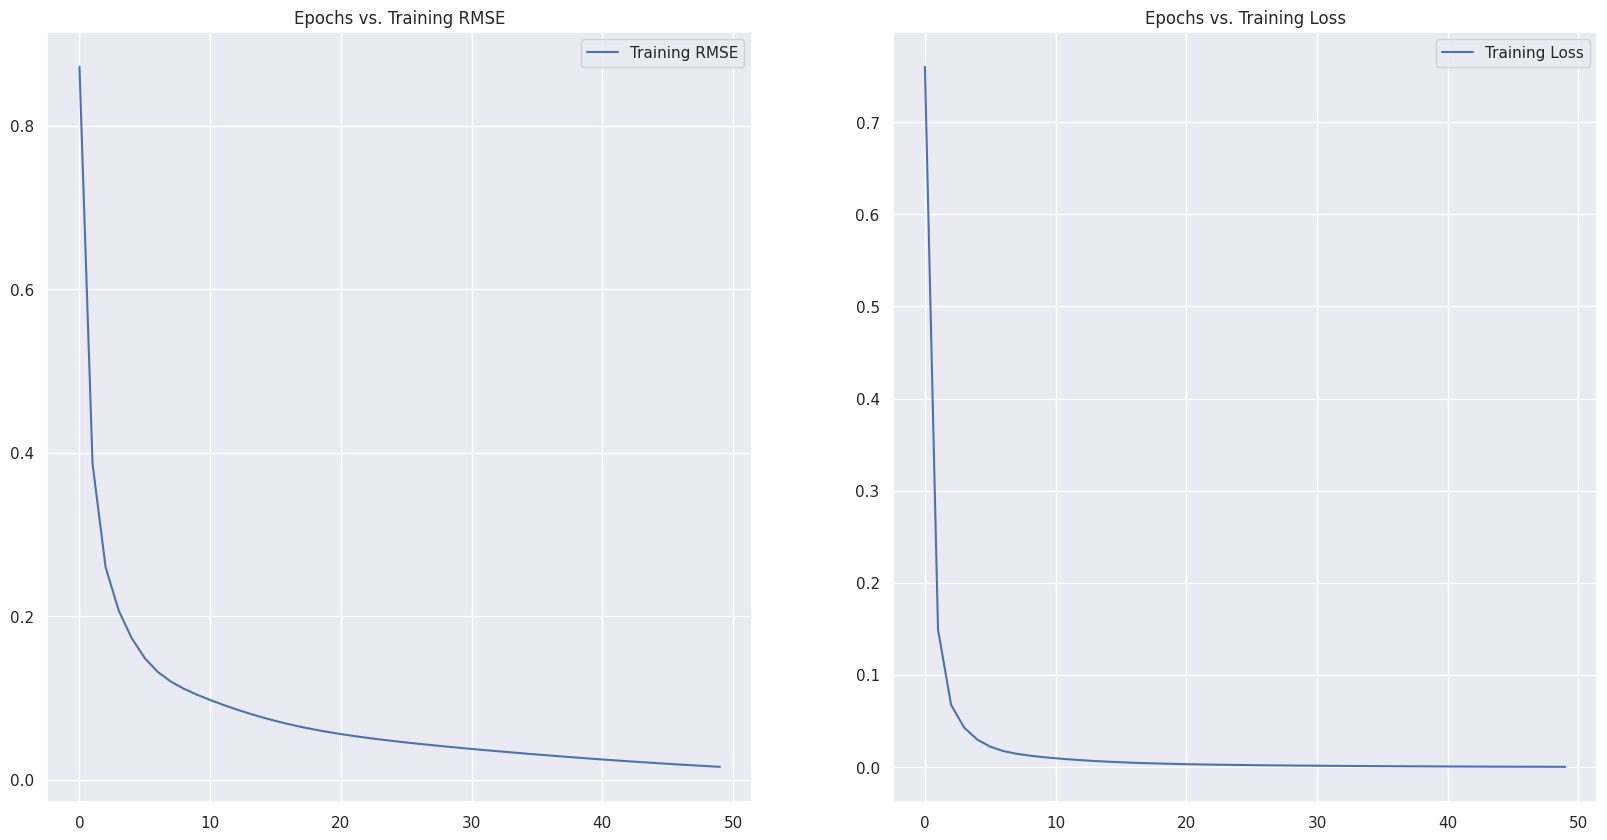

In [124]:
linear_model, linear_history = train(linear_model, train_dataset, 0.001, "checkpoint/Linear.best", 50, 256)

And, finally we evaluate the performance of the model to the test data.

In [125]:
linear_results = test(linear_model, test_dataset)

14/14 [==============================] - 1s 32ms/step
3461
loss: 0.00016484473599120975, rmse: 0.012839187867939472, r2: 0.9998359084129333, mae: 0.008958974853157997, mape: 3.8190832138061523


Train is better than test (Train:0.00000000000095226, Test: 0.000000000022220). r2=1

In my first experiment, test was better than train and both of them were a little worst than my second experiment.

Average Error in MW: 0.1523609892 (27 houses) (mean * mae)

### Neural Network

In [126]:
inputs = keras.Input(shape=(sequence_length,))
print(inputs.shape)

dnn_model = keras.Sequential()
dnn_model.add(keras.layers.Normalization())
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(64, activation='relu'))
dnn_model.add(keras.layers.Dense(1))

dnn_model.build(input_shape = inputs.shape)
dnn_model.summary()

(None, 24)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 24)               49        
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 64)                1600      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,874
Trainable params: 5,825
Non-trainable params: 49
_________________________________________________________________


Then, we train the model to learn the training data.

Epoch 1/3
124/124 [==============================] - ETA: 0s - loss: 0.1537 - r_square: 0.8462 - root_mean_squared_error: 0.3921 - mean_absolute_error: 0.2470 - mean_absolute_percentage_error: 97.3901


Epoch 1: loss improved from inf to 0.15371, saving model to checkpoint/Dnn.best20062023_09:50:23.hdf5
124/124 [==============================] - 6s 40ms/step - loss: 0.1537 - r_square: 0.8462 - root_mean_squared_error: 0.3921 - mean_absolute_error: 0.2470 - mean_absolute_percentage_error: 97.3901
Epoch 2/3
122/124 [============================>.] - ETA: 0s - loss: 0.0139 - r_square: 0.9861 - root_mean_squared_error: 0.1179 - mean_absolute_error: 0.0860 - mean_absolute_percentage_error: 48.0795


Epoch 2: loss improved from 0.15371 to 0.01385, saving model to checkpoint/Dnn.best20062023_09:50:23.hdf5
124/124 [==============================] - 5s 40ms/step - loss: 0.0139 - r_square: 0.9861 - root_mean_squared_error: 0.1177 - mean_absolute_error: 0.0858 - mean_absolute_percentage_error: 47.9480
Epoch 3/3
122/124 [============================>.] - ETA: 0s - loss: 0.0069 - r_square: 0.9930 - root_mean_squared_error: 0.0833 - mean_absolute_error: 0.0612 - mean_absolute_percentage_error: 35.6042


Epoch 3: loss improved from 0.01385 to 0.00693, saving model to checkpoint/Dnn.best20062023_09:50:23.hdf5
124/124 [==============================] - 4s 33ms/step - loss: 0.0069 - r_square: 0.9931 - root_mean_squared_error: 0.0832 - mean_absolute_error: 0.0611 - mean_absolute_percentage_error: 35.4891


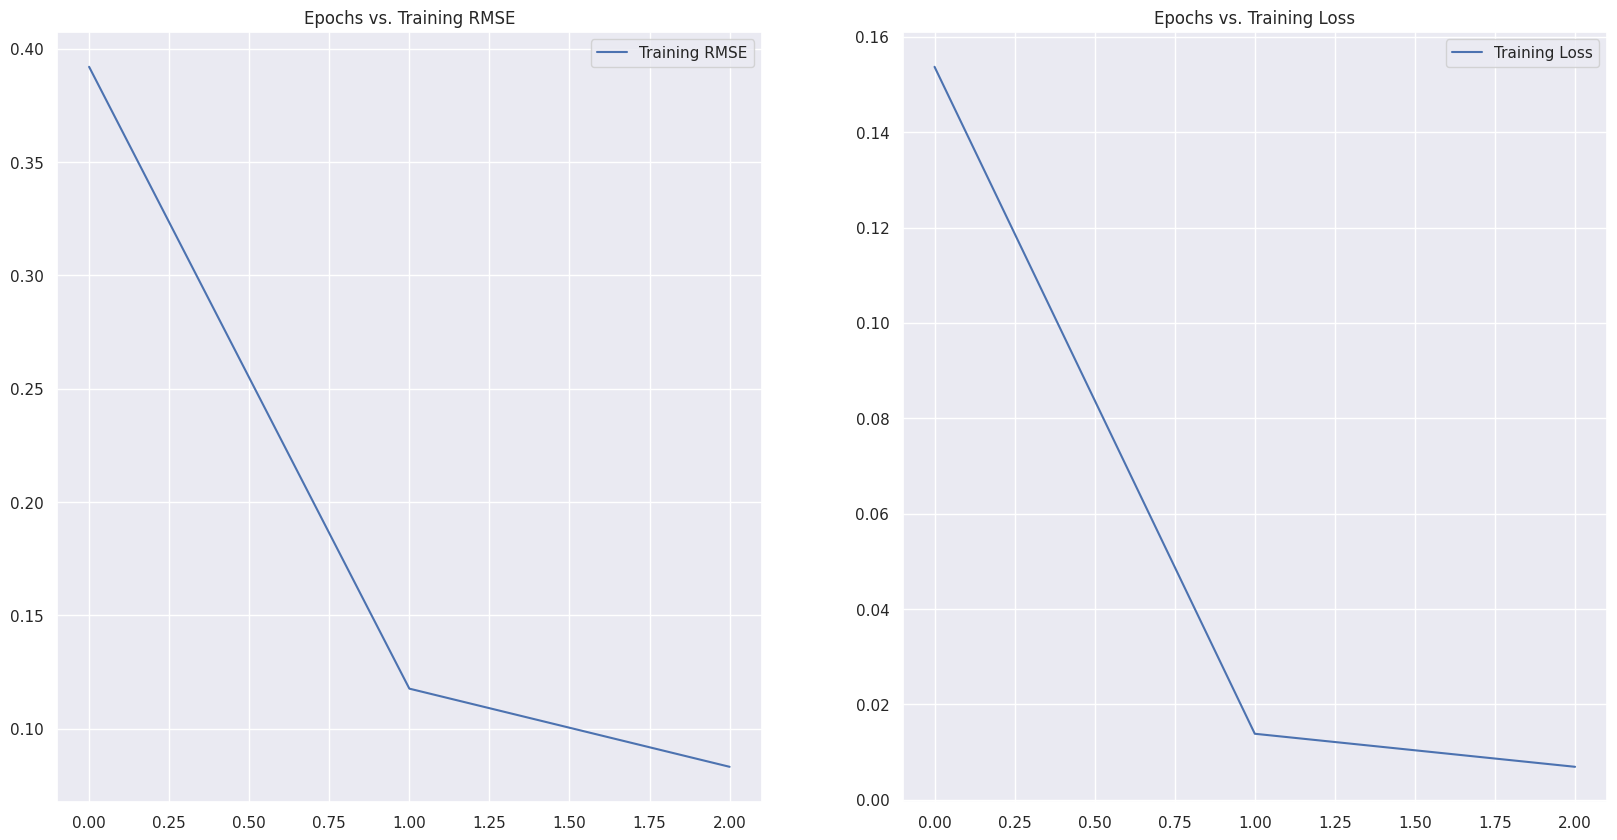

In [127]:
dnn_model, dnn_history = train(dnn_model, train_dataset, 0.001, "checkpoint/Dnn.best", 3, 256)

And, finally we evaluate the performance of the model to the test data.

In [128]:
dnn_results = test(dnn_model, test_dataset)

'''
prediction = dnn_model.predict(test_dataset)
print(prediction)

inv = (prediction*std)+mean

MSE = tf.keras.metrics.MeanSquaredError(test_dataset, inv)
print(MSE)

print(np.sqrt(MSE))
'''

14/14 [==============================] - 1s 32ms/step
3461
loss: 0.004760264419019222, rmse: 0.0689946711063385, r2: 0.9952613711357117, mae: 0.052150532603263855, mape: 27.168283462524414


'\nprediction = dnn_model.predict(test_dataset)\nprint(prediction)\n\ninv = (prediction*std)+mean\n\nMSE = tf.keras.metrics.MeanSquaredError(test_dataset, inv)\nprint(MSE)\n\nprint(np.sqrt(MSE))\n'

Train is better than test. (Train: 0.00005, Test:0.000065593) r2=0.9999

Linear Model is better than Neural Network.

Average Error in MW: 183.5190897 (32300 houses)

### SVM (For Load)

In [129]:
sequence_length = 24
delay = sequence_length -1
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled['total load actual'][:-delay],
    df_scaled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    df_scaled['total load actual'][:-delay],
    df_scaled['total load actual'][delay:],
    sampling_rate = 1,
    sequence_length=24,
    shuffle=False,
    batch_size=batch_size,
    start_index=num_train_samples+1)

In [130]:
for sample, target in train_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

train_ds = train_dataset.unbatch()
train_samples = np.array(list(train_ds.map(lambda x, y: x)))
train_targets = np.array(list(train_ds.map(lambda x, y: y)))

samples shape: (256, 24)
targets shape: (256,)


In [131]:
for sample, target in test_dataset:
    print("samples shape:", sample.shape)
    print("targets shape:", target.shape)
    break

test_ds = test_dataset.unbatch()
test_samples = np.array(list(test_ds.map(lambda x, y: x)))
test_targets = np.array(list(test_ds.map(lambda x, y: y)))

samples shape: (256, 24)
targets shape: (256,)


In [132]:
X = train_samples
y = train_targets
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svm_model = regr.fit(X,y)
svm_history = regr.predict(X)
svm_train = {}
svm_train['mse'] = sklearn.metrics.mean_squared_error(y, svm_history)
svm_train['r2'] = sklearn.metrics.r2_score(y, svm_history)
svm_train['mae'] = sklearn.metrics.mean_absolute_error(y, svm_history)
svm_train['rmse'] = sqrt(svm_train['mse'])
print(svm_train)

{'mse': 0.009692891698783864, 'r2': 0.9903027199070484, 'mae': 0.08553464419940292, 'rmse': 0.09845248447237817}


In [133]:
svm_results = {}

svm_results['predictions'] = regr.predict(test_samples)
print(svm_results['predictions'])

svm_results['mse'] = sklearn.metrics.mean_squared_error(test_targets, svm_results['predictions'])
svm_results['r2'] = sklearn.metrics.r2_score(test_targets, svm_results['predictions'])
svm_results['mae'] = sklearn.metrics.mean_absolute_error(test_targets, svm_results['predictions'])
svm_results['rmse'] = sqrt(svm_results['mse'])
print(svm_results)

[ 1.02515985  0.44690096 -0.45825558 ...  0.20394844 -0.2449357
 -0.83352151]
{'predictions': array([ 1.02515985,  0.44690096, -0.45825558, ...,  0.20394844,
       -0.2449357 , -0.83352151]), 'mse': 0.009483526318398336, 'r2': 0.9905589072122393, 'mae': 0.0845107615567428, 'rmse': 0.09738339857695631}


In [134]:
#Building the support vector regression model
#we will choose the best parameter for SVR model
#kernel = ['poly','sigmoid','rbf', 'linear']
#C = [0.01,0.1,1,10]
#gamma = [0.01,0.1,1]
#epsilon = [0.01,0.1,1]
#shrinking = [True,False]
'''
svm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}
SVM = SVR()
svm_search = RandomizedSearchCV(SVM,svm_grid,cv=3)
svm_history = svm_search.fit(samples,targets)
'''
#svm_search.best_params_
#svm_confirmed = svm_search.best_estimator_
#svm_confirmed

"\nsvm_grid = {'kernel':kernel,'C':C,'gamma':gamma,'epsilon':epsilon,'shrinking':shrinking}\nSVM = SVR()\nsvm_search = RandomizedSearchCV(SVM,svm_grid,cv=3)\nsvm_history = svm_search.fit(samples,targets)\n"

### Transformer Model (For Load)

In [135]:
# Get model hyperparameters
look_back = 24 #7
n_features = 1#4
horizon = 1

# Get directories name
log_dir = "log"

head_size=256
num_heads=4
ff_dim=4
num_transformer_blocks=1 #4
mlp_units=[128]
mlp_dropout=0.4
dropout=0.25

In [136]:
def transformer_encoder(inputs):

        # Normalization and Attention
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
        x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
        x = tf.keras.layers.Dropout(dropout)(x)

        res = x + inputs

        # Feed Forward Part
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
        x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout)(x)
        x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)

        return x+res


In [137]:
inputs = tf.keras.Input(shape=(look_back, n_features))
x = inputs
for _ in range(num_transformer_blocks):
    x = transformer_encoder(x)

x = tf.keras.layers.GlobalAveragePooling1D(data_format="channels_first")(x)
for dim in mlp_units:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)

# output layer
outputs = tf.keras.layers.Dense(horizon)(x)

trans_model = tf.keras.Model(inputs, outputs)

trans_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 24, 1)]      0           []                               
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 24, 1)       2           ['input_6[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 24, 1)       7169        ['layer_normalization_2[0][0]',  
 eadAttention)                                                    'layer_normalization_2[0][0]']  
                                                                                            

Then, we train the model to learn the training data.

Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 0.3589 - r_square: 0.6409 - root_mean_squared_error: 0.5991 - mean_absolute_error: 0.4452 - mean_absolute_percentage_error: 215.6779


Epoch 1: loss improved from inf to 0.35891, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 53s 404ms/step - loss: 0.3589 - r_square: 0.6409 - root_mean_squared_error: 0.5991 - mean_absolute_error: 0.4452 - mean_absolute_percentage_error: 215.6779
Epoch 2/50
124/124 [==============================] - ETA: 0s - loss: 0.1073 - r_square: 0.8927 - root_mean_squared_error: 0.3276 - mean_absolute_error: 0.2536 - mean_absolute_percentage_error: 104.1689


Epoch 2: loss improved from 0.35891 to 0.10730, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 408ms/step - loss: 0.1073 - r_square: 0.8927 - root_mean_squared_error: 0.3276 - mean_absolute_error: 0.2536 - mean_absolute_percentage_error: 104.1689
Epoch 3/50
124/124 [==============================] - ETA: 0s - loss: 0.0597 - r_square: 0.9403 - root_mean_squared_error: 0.2443 - mean_absolute_error: 0.1878 - mean_absolute_percentage_error: 76.7047


Epoch 3: loss improved from 0.10730 to 0.05971, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 393ms/step - loss: 0.0597 - r_square: 0.9403 - root_mean_squared_error: 0.2443 - mean_absolute_error: 0.1878 - mean_absolute_percentage_error: 76.7047
Epoch 4/50
124/124 [==============================] - ETA: 0s - loss: 0.0412 - r_square: 0.9588 - root_mean_squared_error: 0.2029 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 64.7525


Epoch 4: loss improved from 0.05971 to 0.04115, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 399ms/step - loss: 0.0412 - r_square: 0.9588 - root_mean_squared_error: 0.2029 - mean_absolute_error: 0.1548 - mean_absolute_percentage_error: 64.7525
Epoch 5/50
124/124 [==============================] - ETA: 0s - loss: 0.0327 - r_square: 0.9673 - root_mean_squared_error: 0.1808 - mean_absolute_error: 0.1370 - mean_absolute_percentage_error: 52.2494


Epoch 5: loss improved from 0.04115 to 0.03267, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 48s 390ms/step - loss: 0.0327 - r_square: 0.9673 - root_mean_squared_error: 0.1808 - mean_absolute_error: 0.1370 - mean_absolute_percentage_error: 52.2494
Epoch 6/50
124/124 [==============================] - ETA: 0s - loss: 0.0273 - r_square: 0.9727 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 46.9808


Epoch 6: loss improved from 0.03267 to 0.02732, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 400ms/step - loss: 0.0273 - r_square: 0.9727 - root_mean_squared_error: 0.1653 - mean_absolute_error: 0.1247 - mean_absolute_percentage_error: 46.9808
Epoch 7/50
124/124 [==============================] - ETA: 0s - loss: 0.0248 - r_square: 0.9752 - root_mean_squared_error: 0.1574 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 40.5270


Epoch 7: loss improved from 0.02732 to 0.02478, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 401ms/step - loss: 0.0248 - r_square: 0.9752 - root_mean_squared_error: 0.1574 - mean_absolute_error: 0.1176 - mean_absolute_percentage_error: 40.5270
Epoch 8/50
124/124 [==============================] - ETA: 0s - loss: 0.0224 - r_square: 0.9776 - root_mean_squared_error: 0.1496 - mean_absolute_error: 0.1116 - mean_absolute_percentage_error: 41.7022


Epoch 8: loss improved from 0.02478 to 0.02238, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 397ms/step - loss: 0.0224 - r_square: 0.9776 - root_mean_squared_error: 0.1496 - mean_absolute_error: 0.1116 - mean_absolute_percentage_error: 41.7022
Epoch 9/50
124/124 [==============================] - ETA: 0s - loss: 0.0212 - r_square: 0.9788 - root_mean_squared_error: 0.1456 - mean_absolute_error: 0.1082 - mean_absolute_percentage_error: 36.0249


Epoch 9: loss improved from 0.02238 to 0.02121, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 398ms/step - loss: 0.0212 - r_square: 0.9788 - root_mean_squared_error: 0.1456 - mean_absolute_error: 0.1082 - mean_absolute_percentage_error: 36.0249
Epoch 10/50
124/124 [==============================] - ETA: 0s - loss: 0.0199 - r_square: 0.9801 - root_mean_squared_error: 0.1411 - mean_absolute_error: 0.1044 - mean_absolute_percentage_error: 34.7007


Epoch 10: loss improved from 0.02121 to 0.01991, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 400ms/step - loss: 0.0199 - r_square: 0.9801 - root_mean_squared_error: 0.1411 - mean_absolute_error: 0.1044 - mean_absolute_percentage_error: 34.7007
Epoch 11/50
124/124 [==============================] - ETA: 0s - loss: 0.0186 - r_square: 0.9814 - root_mean_squared_error: 0.1363 - mean_absolute_error: 0.1007 - mean_absolute_percentage_error: 32.2075


Epoch 11: loss improved from 0.01991 to 0.01859, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 405ms/step - loss: 0.0186 - r_square: 0.9814 - root_mean_squared_error: 0.1363 - mean_absolute_error: 0.1007 - mean_absolute_percentage_error: 32.2075
Epoch 12/50
124/124 [==============================] - ETA: 0s - loss: 0.0180 - r_square: 0.9820 - root_mean_squared_error: 0.1342 - mean_absolute_error: 0.0986 - mean_absolute_percentage_error: 31.5225


Epoch 12: loss improved from 0.01859 to 0.01800, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 396ms/step - loss: 0.0180 - r_square: 0.9820 - root_mean_squared_error: 0.1342 - mean_absolute_error: 0.0986 - mean_absolute_percentage_error: 31.5225
Epoch 13/50
124/124 [==============================] - ETA: 0s - loss: 0.0176 - r_square: 0.9824 - root_mean_squared_error: 0.1327 - mean_absolute_error: 0.0978 - mean_absolute_percentage_error: 30.9660


Epoch 13: loss improved from 0.01800 to 0.01762, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 404ms/step - loss: 0.0176 - r_square: 0.9824 - root_mean_squared_error: 0.1327 - mean_absolute_error: 0.0978 - mean_absolute_percentage_error: 30.9660
Epoch 14/50
124/124 [==============================] - ETA: 0s - loss: 0.0168 - r_square: 0.9831 - root_mean_squared_error: 0.1298 - mean_absolute_error: 0.0952 - mean_absolute_percentage_error: 28.7229


Epoch 14: loss improved from 0.01762 to 0.01684, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 407ms/step - loss: 0.0168 - r_square: 0.9831 - root_mean_squared_error: 0.1298 - mean_absolute_error: 0.0952 - mean_absolute_percentage_error: 28.7229
Epoch 15/50
124/124 [==============================] - ETA: 0s - loss: 0.0169 - r_square: 0.9831 - root_mean_squared_error: 0.1301 - mean_absolute_error: 0.0954 - mean_absolute_percentage_error: 31.2822


Epoch 15: loss did not improve from 0.01684
124/124 [==============================] - 50s 405ms/step - loss: 0.0169 - r_square: 0.9831 - root_mean_squared_error: 0.1301 - mean_absolute_error: 0.0954 - mean_absolute_percentage_error: 31.2822
Epoch 16/50
124/124 [==============================] - ETA: 0s - loss: 0.0161 - r_square: 0.9839 - root_mean_squared_error: 0.1269 - mean_absolute_error: 0.0935 - mean_absolute_percentage_error: 29.2603


Epoch 16: loss improved from 0.01684 to 0.01611, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 408ms/step - loss: 0.0161 - r_square: 0.9839 - root_mean_squared_error: 0.1269 - mean_absolute_error: 0.0935 - mean_absolute_percentage_error: 29.2603
Epoch 17/50
124/124 [==============================] - ETA: 0s - loss: 0.0157 - r_square: 0.9843 - root_mean_squared_error: 0.1254 - mean_absolute_error: 0.0917 - mean_absolute_percentage_error: 26.6278


Epoch 17: loss improved from 0.01611 to 0.01571, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 407ms/step - loss: 0.0157 - r_square: 0.9843 - root_mean_squared_error: 0.1254 - mean_absolute_error: 0.0917 - mean_absolute_percentage_error: 26.6278
Epoch 18/50
124/124 [==============================] - ETA: 0s - loss: 0.0152 - r_square: 0.9848 - root_mean_squared_error: 0.1234 - mean_absolute_error: 0.0904 - mean_absolute_percentage_error: 28.3252


Epoch 18: loss improved from 0.01571 to 0.01524, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 394ms/step - loss: 0.0152 - r_square: 0.9848 - root_mean_squared_error: 0.1234 - mean_absolute_error: 0.0904 - mean_absolute_percentage_error: 28.3252
Epoch 19/50
124/124 [==============================] - ETA: 0s - loss: 0.0149 - r_square: 0.9851 - root_mean_squared_error: 0.1220 - mean_absolute_error: 0.0891 - mean_absolute_percentage_error: 28.1480


Epoch 19: loss improved from 0.01524 to 0.01488, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 401ms/step - loss: 0.0149 - r_square: 0.9851 - root_mean_squared_error: 0.1220 - mean_absolute_error: 0.0891 - mean_absolute_percentage_error: 28.1480
Epoch 20/50
124/124 [==============================] - ETA: 0s - loss: 0.0148 - r_square: 0.9852 - root_mean_squared_error: 0.1215 - mean_absolute_error: 0.0888 - mean_absolute_percentage_error: 24.6633


Epoch 20: loss improved from 0.01488 to 0.01476, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 407ms/step - loss: 0.0148 - r_square: 0.9852 - root_mean_squared_error: 0.1215 - mean_absolute_error: 0.0888 - mean_absolute_percentage_error: 24.6633
Epoch 21/50
124/124 [==============================] - ETA: 0s - loss: 0.0143 - r_square: 0.9857 - root_mean_squared_error: 0.1195 - mean_absolute_error: 0.0873 - mean_absolute_percentage_error: 25.9765


Epoch 21: loss improved from 0.01476 to 0.01427, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 408ms/step - loss: 0.0143 - r_square: 0.9857 - root_mean_squared_error: 0.1195 - mean_absolute_error: 0.0873 - mean_absolute_percentage_error: 25.9765
Epoch 22/50
124/124 [==============================] - ETA: 0s - loss: 0.0140 - r_square: 0.9860 - root_mean_squared_error: 0.1184 - mean_absolute_error: 0.0863 - mean_absolute_percentage_error: 24.3634


Epoch 22: loss improved from 0.01427 to 0.01402, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 400ms/step - loss: 0.0140 - r_square: 0.9860 - root_mean_squared_error: 0.1184 - mean_absolute_error: 0.0863 - mean_absolute_percentage_error: 24.3634
Epoch 23/50
124/124 [==============================] - ETA: 0s - loss: 0.0140 - r_square: 0.9860 - root_mean_squared_error: 0.1183 - mean_absolute_error: 0.0859 - mean_absolute_percentage_error: 26.0413


Epoch 23: loss improved from 0.01402 to 0.01399, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 58s 470ms/step - loss: 0.0140 - r_square: 0.9860 - root_mean_squared_error: 0.1183 - mean_absolute_error: 0.0859 - mean_absolute_percentage_error: 26.0413
Epoch 24/50
124/124 [==============================] - ETA: 0s - loss: 0.0137 - r_square: 0.9863 - root_mean_squared_error: 0.1171 - mean_absolute_error: 0.0851 - mean_absolute_percentage_error: 23.2149


Epoch 24: loss improved from 0.01399 to 0.01371, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 394ms/step - loss: 0.0137 - r_square: 0.9863 - root_mean_squared_error: 0.1171 - mean_absolute_error: 0.0851 - mean_absolute_percentage_error: 23.2149
Epoch 25/50
124/124 [==============================] - ETA: 0s - loss: 0.0134 - r_square: 0.9866 - root_mean_squared_error: 0.1156 - mean_absolute_error: 0.0843 - mean_absolute_percentage_error: 23.8904


Epoch 25: loss improved from 0.01371 to 0.01336, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 398ms/step - loss: 0.0134 - r_square: 0.9866 - root_mean_squared_error: 0.1156 - mean_absolute_error: 0.0843 - mean_absolute_percentage_error: 23.8904
Epoch 26/50
124/124 [==============================] - ETA: 0s - loss: 0.0136 - r_square: 0.9864 - root_mean_squared_error: 0.1168 - mean_absolute_error: 0.0844 - mean_absolute_percentage_error: 24.4281


Epoch 26: loss did not improve from 0.01336
124/124 [==============================] - 50s 403ms/step - loss: 0.0136 - r_square: 0.9864 - root_mean_squared_error: 0.1168 - mean_absolute_error: 0.0844 - mean_absolute_percentage_error: 24.4281
Epoch 27/50
124/124 [==============================] - ETA: 0s - loss: 0.0134 - r_square: 0.9866 - root_mean_squared_error: 0.1158 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 22.1419


Epoch 27: loss did not improve from 0.01336
124/124 [==============================] - 48s 386ms/step - loss: 0.0134 - r_square: 0.9866 - root_mean_squared_error: 0.1158 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 22.1419
Epoch 28/50
124/124 [==============================] - ETA: 0s - loss: 0.0131 - r_square: 0.9869 - root_mean_squared_error: 0.1142 - mean_absolute_error: 0.0824 - mean_absolute_percentage_error: 22.5608


Epoch 28: loss improved from 0.01336 to 0.01305, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 401ms/step - loss: 0.0131 - r_square: 0.9869 - root_mean_squared_error: 0.1142 - mean_absolute_error: 0.0824 - mean_absolute_percentage_error: 22.5608
Epoch 29/50
124/124 [==============================] - ETA: 0s - loss: 0.0129 - r_square: 0.9871 - root_mean_squared_error: 0.1135 - mean_absolute_error: 0.0819 - mean_absolute_percentage_error: 21.8140


Epoch 29: loss improved from 0.01305 to 0.01289, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 395ms/step - loss: 0.0129 - r_square: 0.9871 - root_mean_squared_error: 0.1135 - mean_absolute_error: 0.0819 - mean_absolute_percentage_error: 21.8140
Epoch 30/50
124/124 [==============================] - ETA: 0s - loss: 0.0127 - r_square: 0.9873 - root_mean_squared_error: 0.1127 - mean_absolute_error: 0.0813 - mean_absolute_percentage_error: 19.6460


Epoch 30: loss improved from 0.01289 to 0.01271, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 48s 387ms/step - loss: 0.0127 - r_square: 0.9873 - root_mean_squared_error: 0.1127 - mean_absolute_error: 0.0813 - mean_absolute_percentage_error: 19.6460
Epoch 31/50
124/124 [==============================] - ETA: 0s - loss: 0.0127 - r_square: 0.9873 - root_mean_squared_error: 0.1126 - mean_absolute_error: 0.0812 - mean_absolute_percentage_error: 21.8033


Epoch 31: loss improved from 0.01271 to 0.01267, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 48s 387ms/step - loss: 0.0127 - r_square: 0.9873 - root_mean_squared_error: 0.1126 - mean_absolute_error: 0.0812 - mean_absolute_percentage_error: 21.8033
Epoch 32/50
124/124 [==============================] - ETA: 0s - loss: 0.0125 - r_square: 0.9875 - root_mean_squared_error: 0.1119 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 21.0528


Epoch 32: loss improved from 0.01267 to 0.01252, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 48s 383ms/step - loss: 0.0125 - r_square: 0.9875 - root_mean_squared_error: 0.1119 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 21.0528
Epoch 33/50
124/124 [==============================] - ETA: 0s - loss: 0.0122 - r_square: 0.9877 - root_mean_squared_error: 0.1107 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 20.1397


Epoch 33: loss improved from 0.01252 to 0.01225, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 391ms/step - loss: 0.0122 - r_square: 0.9877 - root_mean_squared_error: 0.1107 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 20.1397
Epoch 34/50
124/124 [==============================] - ETA: 0s - loss: 0.0122 - r_square: 0.9878 - root_mean_squared_error: 0.1105 - mean_absolute_error: 0.0794 - mean_absolute_percentage_error: 20.3395


Epoch 34: loss improved from 0.01225 to 0.01221, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 399ms/step - loss: 0.0122 - r_square: 0.9878 - root_mean_squared_error: 0.1105 - mean_absolute_error: 0.0794 - mean_absolute_percentage_error: 20.3395
Epoch 35/50
124/124 [==============================] - ETA: 0s - loss: 0.0125 - r_square: 0.9875 - root_mean_squared_error: 0.1119 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 19.7132


Epoch 35: loss did not improve from 0.01221
124/124 [==============================] - 48s 391ms/step - loss: 0.0125 - r_square: 0.9875 - root_mean_squared_error: 0.1119 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 19.7132
Epoch 36/50
124/124 [==============================] - ETA: 0s - loss: 0.0122 - r_square: 0.9878 - root_mean_squared_error: 0.1104 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 19.5296


Epoch 36: loss improved from 0.01221 to 0.01219, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 410ms/step - loss: 0.0122 - r_square: 0.9878 - root_mean_squared_error: 0.1104 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 19.5296
Epoch 37/50
124/124 [==============================] - ETA: 0s - loss: 0.0120 - r_square: 0.9880 - root_mean_squared_error: 0.1097 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 19.9523


Epoch 37: loss improved from 0.01219 to 0.01204, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 50s 399ms/step - loss: 0.0120 - r_square: 0.9880 - root_mean_squared_error: 0.1097 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 19.9523
Epoch 38/50
124/124 [==============================] - ETA: 0s - loss: 0.0119 - r_square: 0.9880 - root_mean_squared_error: 0.1093 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 19.2647


Epoch 38: loss improved from 0.01204 to 0.01195, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 395ms/step - loss: 0.0119 - r_square: 0.9880 - root_mean_squared_error: 0.1093 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 19.2647
Epoch 39/50
124/124 [==============================] - ETA: 0s - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1086 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 19.7981


Epoch 39: loss improved from 0.01195 to 0.01179, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 395ms/step - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1086 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 19.7981
Epoch 40/50
124/124 [==============================] - ETA: 0s - loss: 0.0119 - r_square: 0.9881 - root_mean_squared_error: 0.1089 - mean_absolute_error: 0.0779 - mean_absolute_percentage_error: 18.2970


Epoch 40: loss did not improve from 0.01179
124/124 [==============================] - 49s 391ms/step - loss: 0.0119 - r_square: 0.9881 - root_mean_squared_error: 0.1089 - mean_absolute_error: 0.0779 - mean_absolute_percentage_error: 18.2970
Epoch 41/50
124/124 [==============================] - ETA: 0s - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1085 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 18.6772


Epoch 41: loss improved from 0.01179 to 0.01176, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 48s 384ms/step - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1085 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 18.6772
Epoch 42/50
124/124 [==============================] - ETA: 0s - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1082 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 17.7391


Epoch 42: loss improved from 0.01176 to 0.01170, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 51s 408ms/step - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1082 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 17.7391
Epoch 43/50
124/124 [==============================] - ETA: 0s - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1086 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 18.0825


Epoch 43: loss did not improve from 0.01170
124/124 [==============================] - 49s 392ms/step - loss: 0.0118 - r_square: 0.9882 - root_mean_squared_error: 0.1086 - mean_absolute_error: 0.0772 - mean_absolute_percentage_error: 18.0825
Epoch 44/50
124/124 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1066 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 18.1447


Epoch 44: loss improved from 0.01170 to 0.01136, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 392ms/step - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1066 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 18.1447
Epoch 45/50
124/124 [==============================] - ETA: 0s - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1080 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.2807


Epoch 45: loss did not improve from 0.01136
124/124 [==============================] - 51s 407ms/step - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1080 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.2807
Epoch 46/50
124/124 [==============================] - ETA: 0s - loss: 0.0113 - r_square: 0.9887 - root_mean_squared_error: 0.1063 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 17.6363


Epoch 46: loss improved from 0.01136 to 0.01130, saving model to checkpoint/Transformer.best20062023_09:51:16.hdf5
124/124 [==============================] - 49s 395ms/step - loss: 0.0113 - r_square: 0.9887 - root_mean_squared_error: 0.1063 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 17.6363
Epoch 47/50
124/124 [==============================] - ETA: 0s - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1082 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 18.4183


Epoch 47: loss did not improve from 0.01130
124/124 [==============================] - 49s 395ms/step - loss: 0.0117 - r_square: 0.9883 - root_mean_squared_error: 0.1082 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 18.4183
Epoch 48/50
124/124 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1068 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 16.9336


Epoch 48: loss did not improve from 0.01130
124/124 [==============================] - 49s 393ms/step - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1068 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 16.9336
Epoch 49/50
124/124 [==============================] - ETA: 0s - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1066 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 18.4774


Epoch 49: loss did not improve from 0.01130
124/124 [==============================] - 50s 404ms/step - loss: 0.0114 - r_square: 0.9886 - root_mean_squared_error: 0.1066 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 18.4774
Epoch 50/50
124/124 [==============================] - ETA: 0s - loss: 0.0115 - r_square: 0.9885 - root_mean_squared_error: 0.1074 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 17.3674


Epoch 50: loss did not improve from 0.01130
124/124 [==============================] - 57s 459ms/step - loss: 0.0115 - r_square: 0.9885 - root_mean_squared_error: 0.1074 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 17.3674


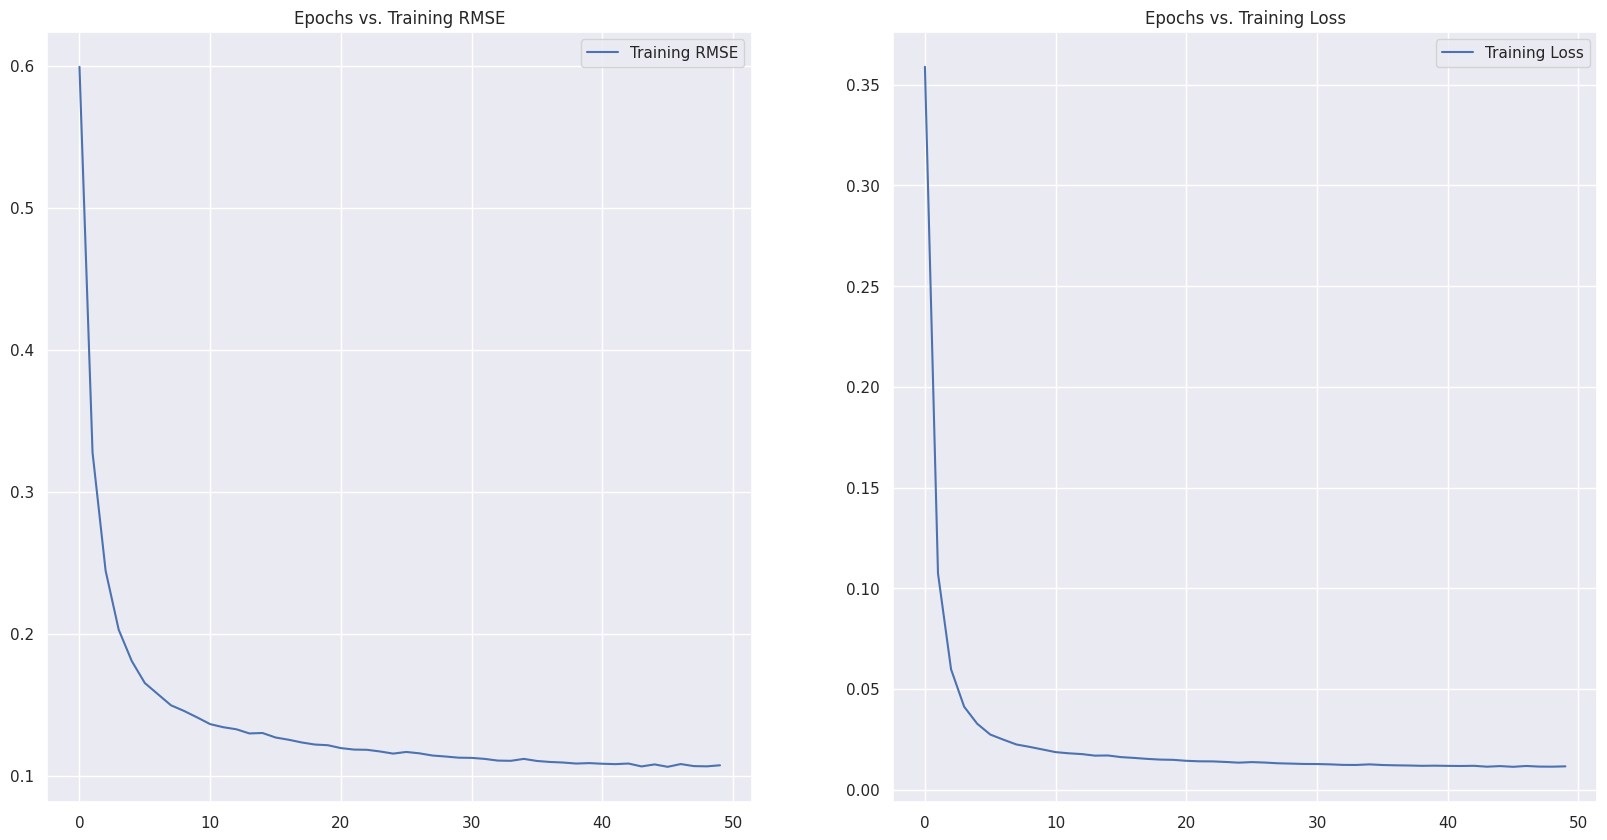

'\n\ndef train(train,\n        epochs=50,\n        batch_size=256):\n        """ Training the network\n        :param X_train: training feature vectors [#batch,#number_of_timesteps,#number_of_features]\n        :type 3-D Numpy array of float values\n        :param Y_train: training target vectors\n        :type 2-D Numpy array of float values\n        :param epochs: number of training epochs\n        :type int\n        :param batch_size: size of batches used at each forward/backward propagation\n        :type int\n        :return -\n        :raises: -\n        """\n\n\n        # model.fit(x, y, epochs=50, callbacks=[lr_scheduler])\n        optimizer = tf.keras.optimizers.Adam(lr=0.01, amsgrad=True)\n\n        model = build()\n\n        model.compile(optimizer=optimizer, loss=\'mean_squared_error\',\n                      metrics = [tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]\n     

In [138]:
trans_model, trans_history = train(trans_model, train_dataset, 0.01, "checkpoint/Transformer.best", 50, 256)

'''

def train(train,
        epochs=50,
        batch_size=256):
        """ Training the network
        :param X_train: training feature vectors [#batch,#number_of_timesteps,#number_of_features]
        :type 3-D Numpy array of float values
        :param Y_train: training target vectors
        :type 2-D Numpy array of float values
        :param epochs: number of training epochs
        :type int
        :param batch_size: size of batches used at each forward/backward propagation
        :type int
        :return -
        :raises: -
        """


        # model.fit(x, y, epochs=50, callbacks=[lr_scheduler])
        optimizer = tf.keras.optimizers.Adam(lr=0.01, amsgrad=True)

        model = build()

        model.compile(optimizer=optimizer, loss='mean_squared_error',
                      metrics = [tfa.metrics.RSquare(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]
                           )
        print(model.summary())

        # Stop training if error does not improve within 50 iterations
        early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)

        # Save the best model ... with minimal error
        filepath = checkpoint_dir+"/Transformer.best"+datetime.now().strftime('%d%m%Y_%H:%M:%S')+".hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

        # Reduce the learning rate every few epochs
        # lr_scheduler = LearningRateScheduler(decay_schedule)


        history = model.fit(train, epochs=epochs, batch_size=batch_size,
                             #validation_split=0.2,
                             verbose=1,
                             callbacks=[early_stopping_monitor, checkpoint])
                             #callbacks=[PlotLossesKeras(), early_stopping_monitor, checkpoint])
        return model, history
'''

And, finally we evaluate the performance of the model to the test data.

In [139]:
trans_results = test(trans_model, test_dataset)

14/14 [==============================] - 2s 135ms/step
3460
loss: 0.0004953861935064197, rmse: 0.02225727215409279, r2: 0.9995068311691284, mae: 0.017549851909279823, mape: 5.456296443939209


Test is better than train (Train: 0.0134, Test: 0.00031127). r2=0.9996

Transformer is worse than linear and dnn models.

Average Error in MW: 461.66521 (81254 houses)

## Plotting Results

In this section, we are plotting and comparing the results of all the methods.

### Metrics

First, we are plotting the progression of the metrics values in the training set as well as the same metrics for the test set.

Train


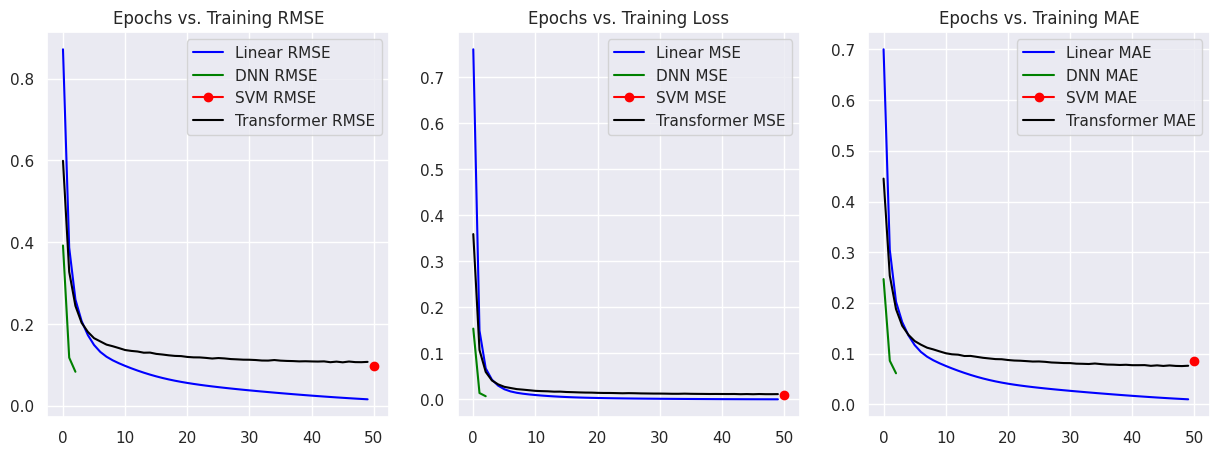

Test


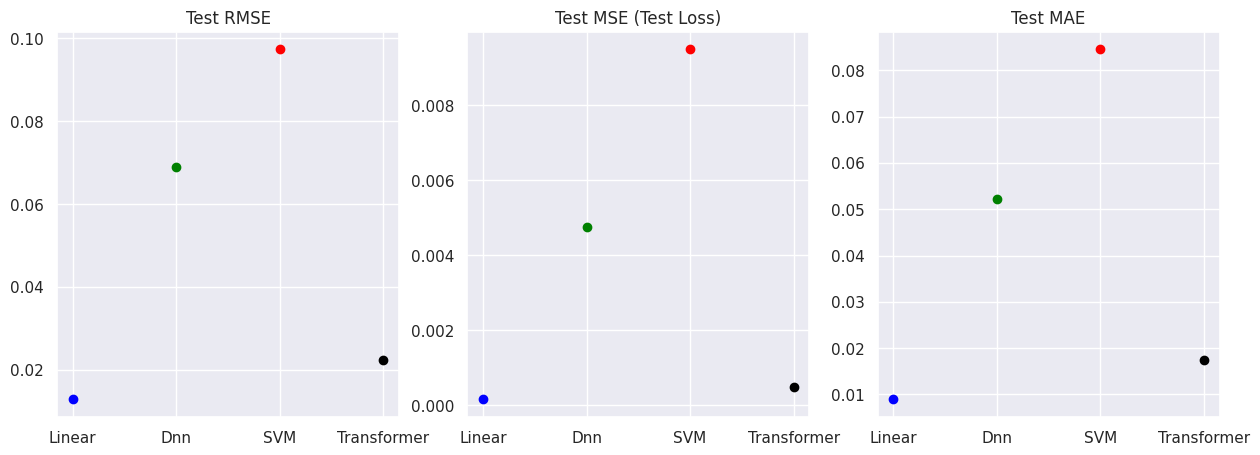

In [146]:
print('Train')
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(linear_history.history['root_mean_squared_error'], label='Linear RMSE', color='blue')
plt.plot(dnn_history.history['root_mean_squared_error'], label='DNN RMSE', color='green')
plt.plot(50, svm_train['rmse'], label='SVM RMSE', color='red', marker='o')
plt.plot(trans_history.history['root_mean_squared_error'], label='Transformer RMSE', color='black')
plt.legend()
plt.title('Epochs vs. Training RMSE')

plt.subplot(1, 3, 2)
plt.plot(linear_history.history['loss'], label='Linear MSE', color='blue')
plt.plot(dnn_history.history['loss'], label='DNN MSE', color='green')
plt.plot(50, svm_train['mse'], label='SVM MSE', color='red', marker='o')
plt.plot(trans_history.history['loss'], label='Transformer MSE', color='black')
plt.legend()
plt.title('Epochs vs. Training Loss')

plt.subplot(1, 3, 3)
plt.plot(linear_history.history['mean_absolute_error'], label='Linear MAE', color='blue')
plt.plot(dnn_history.history['mean_absolute_error'], label='DNN MAE', color='green')
plt.plot(50, svm_train['mae'], label='SVM MAE', color='red', marker='o')
plt.plot(trans_history.history['mean_absolute_error'], label='Transformer MAE', color='black')
plt.legend()
plt.title('Epochs vs. Training MAE')
plt.show()

print('Test')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ar = linear_results['rmse']
plt.plot("Linear", ar, label='Linear RMSE', color='blue', marker='o')
ar = dnn_results['rmse']
plt.plot("Dnn", ar, label='DNN RMSE', color='green', marker='o')
ar = svm_results['rmse']
plt.plot("SVM", ar, label='SVM RMSE', color='red', marker='o')
ar = trans_results['rmse']
plt.plot("Transformer", ar, label='Transformer RMSE', color='black', marker='o')
plt.title('Test RMSE')

plt.subplot(1, 3, 2)
ar = linear_results['loss']
plt.plot("Linear", ar, label='Linear MSE', color='blue', marker='o')
ar = dnn_results['loss']
plt.plot("Dnn", ar, label='DNN MSE', color='green', marker='o')
ar = svm_results['mse']
plt.plot("SVM", ar, label='SVM MSE', color='red', marker='o')
ar = trans_results['loss']
plt.plot("Transformer", ar, label='Transformer MSE', color='black', marker='o')
plt.title('Test MSE (Test Loss)')

plt.subplot(1, 3, 3)
ar = linear_results['mae']
plt.plot("Linear", ar, label='Linear MAE', color='blue', marker='o')
ar = dnn_results['mae']
plt.plot("Dnn", ar, label='DNN MAE', color='green',marker='o')
ar = svm_results['mae']
plt.plot("SVM", ar, label='SVM MAE', color='red',marker='o')
ar = trans_results['mae']
plt.plot("Transformer", ar, label='Transformer MAE', color='black',marker='o')
plt.title('Test MAE')

plt.show()

### Predictions

First, we are plotting the predictions of the models in the test set and we are comparing them to the actual values given in the dataset. We are also plotting the prediction values of the forecast made by the Spanish TSO and given in the dataset.

In [147]:
import plotly.express as px
import plotly.graph_objects as go

invl = (linear_results['predictions']* std['total load actual'])+mean['total load actual']
l = invl.flatten()
invd = (dnn_results['predictions']* std['total load actual'])+mean['total load actual']
d = invd.flatten()
#s = regr.inverse_transform(test_samples,svm_results['predictions']).flatten()
invt = (trans_results['predictions']* std['total load actual'])+mean['total load actual']
t = invt.flatten()

df1 = (df_filled['total load actual'][num_train_samples:]*std['total load actual'])+mean['total load actual']
df1.index = df.index[num_train_samples:]
df2 = (df_filled['total load forecast'][num_train_samples:]*std['total load actual'])+mean['total load actual']
df2.index = df.index[num_train_samples:]
df3 = pd.Series(l)
df3.index = df.index[num_train_samples+23:-23]
df4 = pd.Series(d)
df4.index = df.index[num_train_samples+23:-23]
#df5 = pd.Series(s)
#df5.index = df.index[num_train_samples+23:-23]
df5 = pd.Series(t)
df5.index = df.index[num_train_samples+24:-23]

# dict for the dataframes and their names
dfs = {"df1": df1, "df2": df2, "df3" : df3, "df4" : df4, "df5" : df5}#, "df6" : df6}

# plot the data
fig = go.Figure()

for i in dfs:
    fig = fig.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))
fig.show()

df7 = df1-df2
df7.index = df.index[num_train_samples:]
df8 = df1-df3
df8.index = df.index[num_train_samples:]
df9 = df1-df4
df9.index = df.index[num_train_samples:]
df10 = df1-df5
df10.index = df.index[num_train_samples:]
#df5 = pd.Series(s)
#df5.index = df.index[num_train_samples+23:-23]
#df5 = pd.Series(t)
#df5.index = df.index[num_train_samples+24:-23]

# dict for the dataframes and their names
dfs = {"df7": df7, "df8": df8, "df9" : df9, "df10" : df10}#, "df6" : df6}

# plot the data
fig1 = go.Figure()

for i in dfs:
    fig1 = fig1.add_trace(go.Scatter(x = dfs[i].index,
                                   y = dfs[i],
                                   name = i))
fig1.show()

print("TSO Forecast Mean Difference {}".format(df7.mean()))
print("Linear Forecast Mean Difference {}".format(df8.mean()))
print("DNN Forecast Mean Difference {}".format(df9.mean()))
print("Transformer Forecast Mean Difference {}".format(df10.mean()))

print("TSO Forecast Max Difference {}".format(df7.max()))
print("Linear Forecast Max Difference {}".format(df8.max()))
print("DNN Forecast Max Difference {}".format(df9.max()))
print("Transformer Forecast Max Difference {}".format(df10.max()))

print("TSO Forecast Min Difference {}".format(df7.min()))
print("Linear Forecast Min Difference {}".format(df8.min()))
print("DNN Forecast Min Difference {}".format(df9.min()))
print("Transformer Forecast Min Difference {}".format(df10.min()))

TSO Forecast Mean Difference 45.40863779440272
Linear Forecast Mean Difference -0.06821095781566021
DNN Forecast Mean Difference 25.336945946800057
Transformer Forecast Mean Difference 59.164246522760116
TSO Forecast Max Difference 1946.3250583758017
Linear Forecast Max Difference 485.3828125
DNN Forecast Max Difference 1936.716796875
Transformer Forecast Max Difference 300.337890625
TSO Forecast Min Difference -1832.8600733357707
Linear Forecast Min Difference -478.576171875
DNN Forecast Min Difference -1638.951171875
Transformer Forecast Min Difference -147.53515625


Solution 1:

In [151]:
# How to run a Dash app in Google Colab

## Requirements

### Install ngrok
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

### Run ngrok to tunnel Dash app port 8050 to the outside world. 
### This command runs in the background.
#get_ipython().system_raw('./ngrok http 8050 &')

### Get the public URL where you can access the Dash app. Copy this URL.
#! curl -s http://localhost:4040/api/tunnels | python3 -c \
#    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

### Install Dash
#!pip install dash==0.31.1  # The core dash backend
#!pip install dash-html-components==0.13.2  # HTML components
#!pip install dash-core-components==0.39.0  # Supercharged components
#!pip install dash-table==3.1.7  # Interactive DataTable component (new!)

--2023-06-20 12:39:39--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.237.133.81, 18.205.222.128, 54.161.241.46, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.237.133.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  19.6MB/s    in 0.7s    

2023-06-20 12:39:40 (19.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
Traceback (most recent call last):
  File "<string>", line 1, in <module>
IndexError: list index out of range
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
  Preparing meta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dash-html-components: filename=dash_html_components-0.13.2-py3-none-any.whl size=471430 sha256=f769d342fe9521656a444764347f4fced9a3527c5c5ea1e20609260e7f2804fe
  Stored in directory: /root/.cache/pip/wheels/de/b2/0a/39f6ab5ca5940c8f5a46b20b2955b49fb1b641d8bccea0ab9a
Successfully built dash-html-components
  Attempting uninstall: dash-html-components
    Found existing installation: dash-html-components 2.0.0
    Uninstalling dash-html-components-2.0.0:
      Successfully uninstalled dash-html-components-2.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dash-c

In [152]:
## Dash app (https://dash.plot.ly/getting-started)

### Save file with Dash app on the Google Colab machine
#%%writefile my_app1.py
#import dash
#import dash_core_components as dcc
#import dash_html_components as html

#external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

#app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

#app.layout = html.Div(children=[
#    html.H1(children='Hello Dash'),

    #html.Div(children='''
     #   Dash: A web application framework for Python.
    #'''),

    #dcc.Graph(
     #   id='example-graph',
      #  figure= fig
    #)
#])

#if __name__ == '__main__':
 #   app.run_server(debug=True)

Writing my_app1.py


In [153]:
### Run Dash app
#!python my_app1.py

Traceback (most recent call last):
  File "/content/my_app1.py", line 1, in <module>
    import dash
  File "/usr/local/lib/python3.10/dist-packages/dash/__init__.py", line 1, in <module>
    from .dash import Dash  # noqa: F401
  File "/usr/local/lib/python3.10/dist-packages/dash/dash.py", line 25, in <module>
    from .resources import Scripts, Css
  File "/usr/local/lib/python3.10/dist-packages/dash/resources.py", line 5, in <module>
    from .development.base_component import ComponentRegistry
  File "/usr/local/lib/python3.10/dist-packages/dash/development/__init__.py", line 1, in <module>
    from . import base_component  # noqa:F401
  File "/usr/local/lib/python3.10/dist-packages/dash/development/base_component.py", line 67, in <module>
    class Component(collections.MutableMapping):
AttributeError: module 'collections' has no attribute 'MutableMapping'


Solution 2:

In [142]:
#from google.colab.output import eval_js
#print(eval_js("google.colab.kernel.proxyPort(8050)"))
#!python -m http.server 8050

In [150]:
#from IPython.display import Javascript

#def show_port(port, height=400):
 # display(Javascript("""
  #(async ()=>{
   # fm = document.createElement('iframe')
    #fm.src = await google.colab.kernel.proxyPort(%s)
    #fm.width = '95%%'
    #fm.height = '%d'
    #fm.frameBorder = 0
    #document.body.append(fm)
  #})();
  """ % (port, height) ))
  get_ipython().system_raw('python3 -m http.server 8888 &') 
show_port(8888)

<IPython.core.display.Javascript object>

Solution 3:

In [144]:
#!pip install dash
#from dash import Dash, dcc, html
#from base64 import b64encode
#import io

#app = Dash(__name__)

#buffer = io.StringIO()

# plot the data
#fig = go.Figure()

#for i in dfs:
 #   fig = fig.add_trace(go.Scatter(x = dfs[i].index,
 #                                  y = dfs[i],
#                                 name = i))
#fig1 = go.Figure()

#for i in dfs:
 #   fig1 = fig1.add_trace(go.Scatter(x = dfs[i].index,
  #                                 y = dfs[i],
   #                                name = i))

#fig.write_html(buffer)
#fig1.write_html(buffer)

#html_bytes = buffer.getvalue().encode()
#encoded = b64encode(html_bytes).decode()

#app.layout = html.Div([
#    html.H4('Simple plot export options'),
 #   html.P("↓↓↓ try downloading the plot as PNG ↓↓↓", style={"text-align": "right", "font-weight": "bold"}),
  #  dcc.Graph(id="graph", figure=fig),
   # html.A(
    #    html.Button("Download as HTML"),
     #   id="download",
      #  href="data:text/html;base64," + encoded,
       # download="plotly_graph.html"
   # )
#])


#app.run_server(debug=True, use_reloader=False)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.2 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.0
    Uninstalling Werkzeug-2.3.0:
      Successfully uninstalled Werkzeug-2.3.0
Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



 * Serving Flask app '__main__'
 * Debug mode: on


In [145]:
#with open('/content/drive/MyDrive/Thesis/Transformer_Thesis/p_graph.html', 'a') as f:
#    f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
#    f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))

Solution 4:

In [154]:
!pip install jupyter-dash pyngrok -q
!pip install dash-cytoscape -q
from pyngrok import ngrok
tunnel = ngrok.connect(8050)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 30.5 MB/s eta 0:00:00


In [156]:
from jupyter_dash import JupyterDash  # pip install dash
import dash_cytoscape as cyto  # pip install dash-cytoscape==0.2.0 or higher
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input
import pandas as pd  # pip install pandas
import plotly.express as px
import math
from dash import no_update


external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
app = JupyterDash(__name__, external_stylesheets=external_stylesheets, server_url=tunnel.public_url)

df = pd.read_csv("https://raw.githubusercontent.com/Coding-with-Adam/Dash-by-Plotly/master/Cytoscape/org-data.csv")

app.layout = html.Div([
    html.Div([
        dcc.Graph(id='my-graph', figure=fig)
    ], className='five columns'),

], className='row')


app.run_server(mode='external')

/usr/local/lib/python3.10/dist-packages/jupyter_dash/jupyter_app.py:137: UserWarning:

The server_url argument is ignored when running in Colab



Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



Dash app running on:


<IPython.core.display.Javascript object>